## KP Slc4a11-MCD mTmG traced mice
1/20/2025 - Data generated from 17 week KP Slc4a11-MCD mTmG mice treated with Cisplatin vs MRTX for 3 weeks; data submitted by CHP/EB on 10/11/2024, analyzed by JC 1/8/2025

Analyze global run with GEM-X and now cellranger v8.0.1 data with introns and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/IGO16562-mTmG-3week-treated.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_IGO16562-filtered_feature_bc_matrix_wintron.h5', gex_only=False)

reading GSE277777_IGO16562-filtered_feature_bc_matrix_wintron.h5
 (0:00:03)


/Users/chanj2/opt/miniconda3/envs/scbackup3-cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [9]:
hashadata.var

gene_ids     feature_types genome                    pattern  \
BJ1759_B0301   BJ1759  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1673_B0302   BJ1673  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1609_B0303   BJ1609  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1670_B0304   BJ1670  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BK1145_B0305   BK1145  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1836_B0306   BJ1836  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BK1009_B0307   BK1009  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BK1010_B0308   BK1010  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BK1011_B0309   BK1011  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BK1013_B0310   BK1013  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
BJ1656_B0311   BJ1656  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   

             read         sequence  
BJ1759_B0301   R2  ACCCACCAGTAAGAC  
BJ1673_B0302   R2  GGTCGAGAGCATTCA  
BJ1609_B0303   R2  CTTGCCGCATGTCAT  
BJ1670_B0304   R2  AAAGCATTCTTCACG  
BK1145_B0305   R2  CTTTGTCTTTGTGAG  
BJ1836_B0306   R2  TATGCTGCCACGGTA  
BK1009_B0307   R2  GAGTCTGCCAGTATC  
BK1010_B0308   R2  TATAGAACGCCAGGC  
BK1011_B0309   R2  TGCCTATGAAACAAG  
BK1013_B0310   R2  CCGATTGTAACAGAC  
BJ1656_B0311   R2  GCTTACCGAATTAAC

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


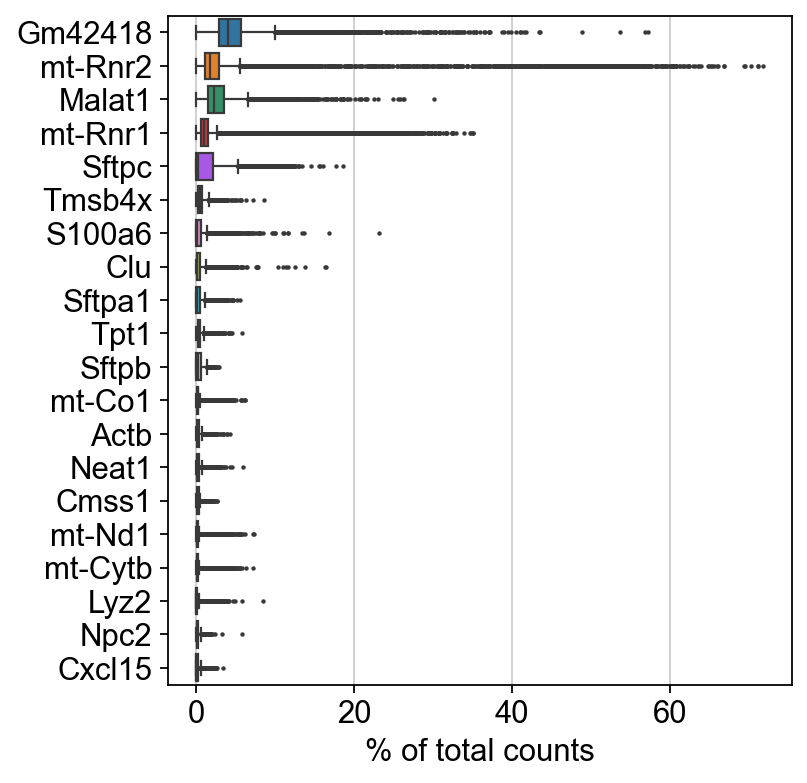

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [11]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1669 cells that have less than 1500 counts
filtered out 70 cells that have less than 300 genes expressed
filtered out 26157 genes that are detected in less than 3 cells


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

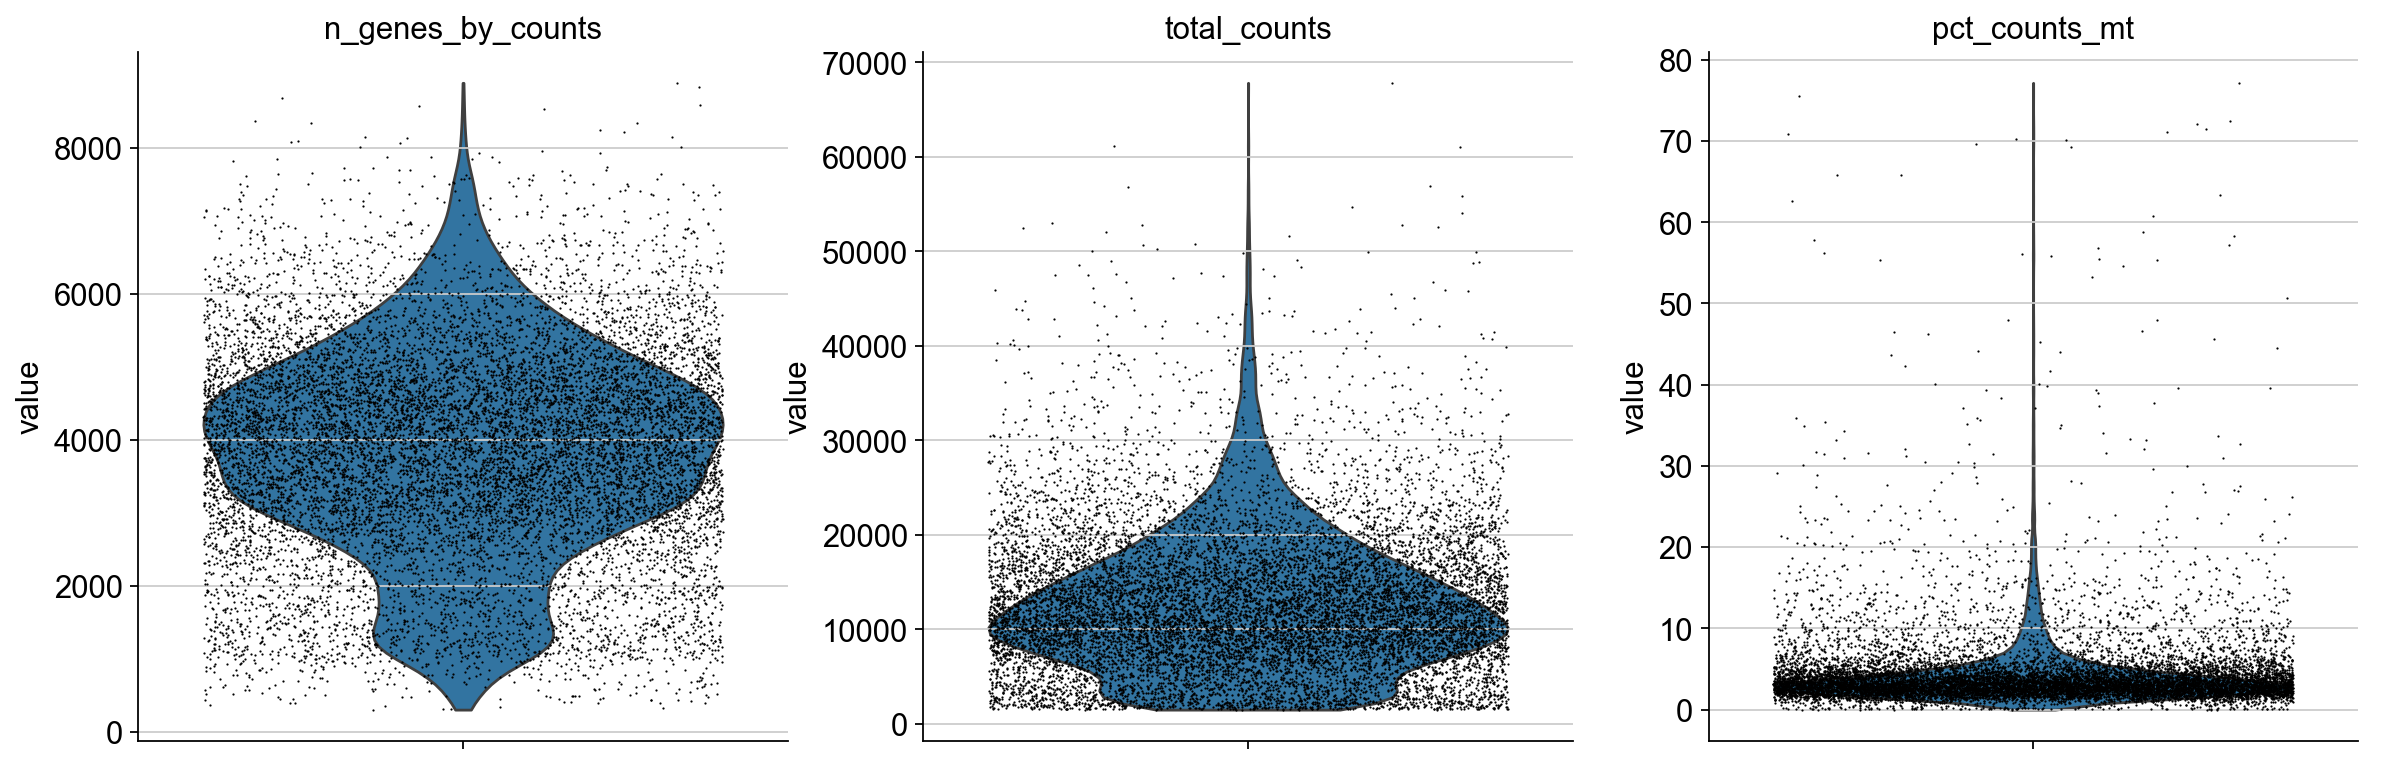

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([4.000e+00, 7.000e+00, 1.900e+01, 4.000e+01, 1.620e+02, 1.414e+03,
        5.474e+03, 4.274e+03, 1.142e+03, 2.940e+02]),
 array([0.72180576, 0.74496874, 0.76813172, 0.7912947 , 0.81445768,
        0.83762066, 0.86078363, 0.88394661, 0.90710959, 0.93027257,
        0.95343555]),
 <BarContainer object of 10 artists>)

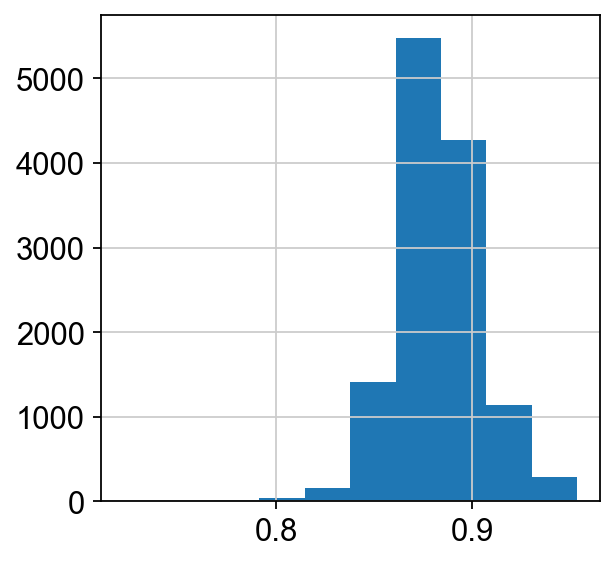

In [14]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

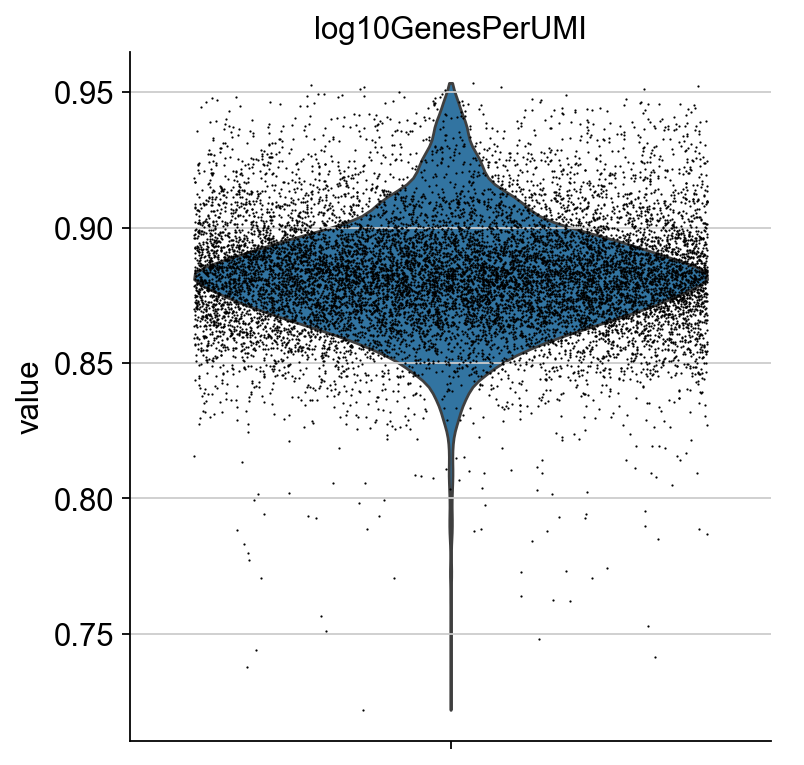

In [15]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [16]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [17]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [18]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [19]:
hashadata.var_names

Index(['BJ1759_B0301', 'BJ1673_B0302', 'BJ1609_B0303', 'BJ1670_B0304',
       'BK1145_B0305', 'BJ1836_B0306', 'BK1009_B0307', 'BK1010_B0308',
       'BK1011_B0309', 'BK1013_B0310', 'BJ1656_B0311'],
      dtype='object')

In [20]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [21]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
#hashDisc

In [22]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
#hashIDs

BJ1759_B0301
3.0
BJ1673_B0302
98.0
BJ1609_B0303
27.0
BJ1670_B0304
1.0
BK1145_B0305
4.0
BJ1836_B0306
2.0
BK1009_B0307
2.0
BK1010_B0308
9.0
BK1011_B0309
5.0
BK1013_B0310
1.0
BJ1656_B0311
185.70000000000073


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [23]:
from matplotlib import pyplot as plt

In [24]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

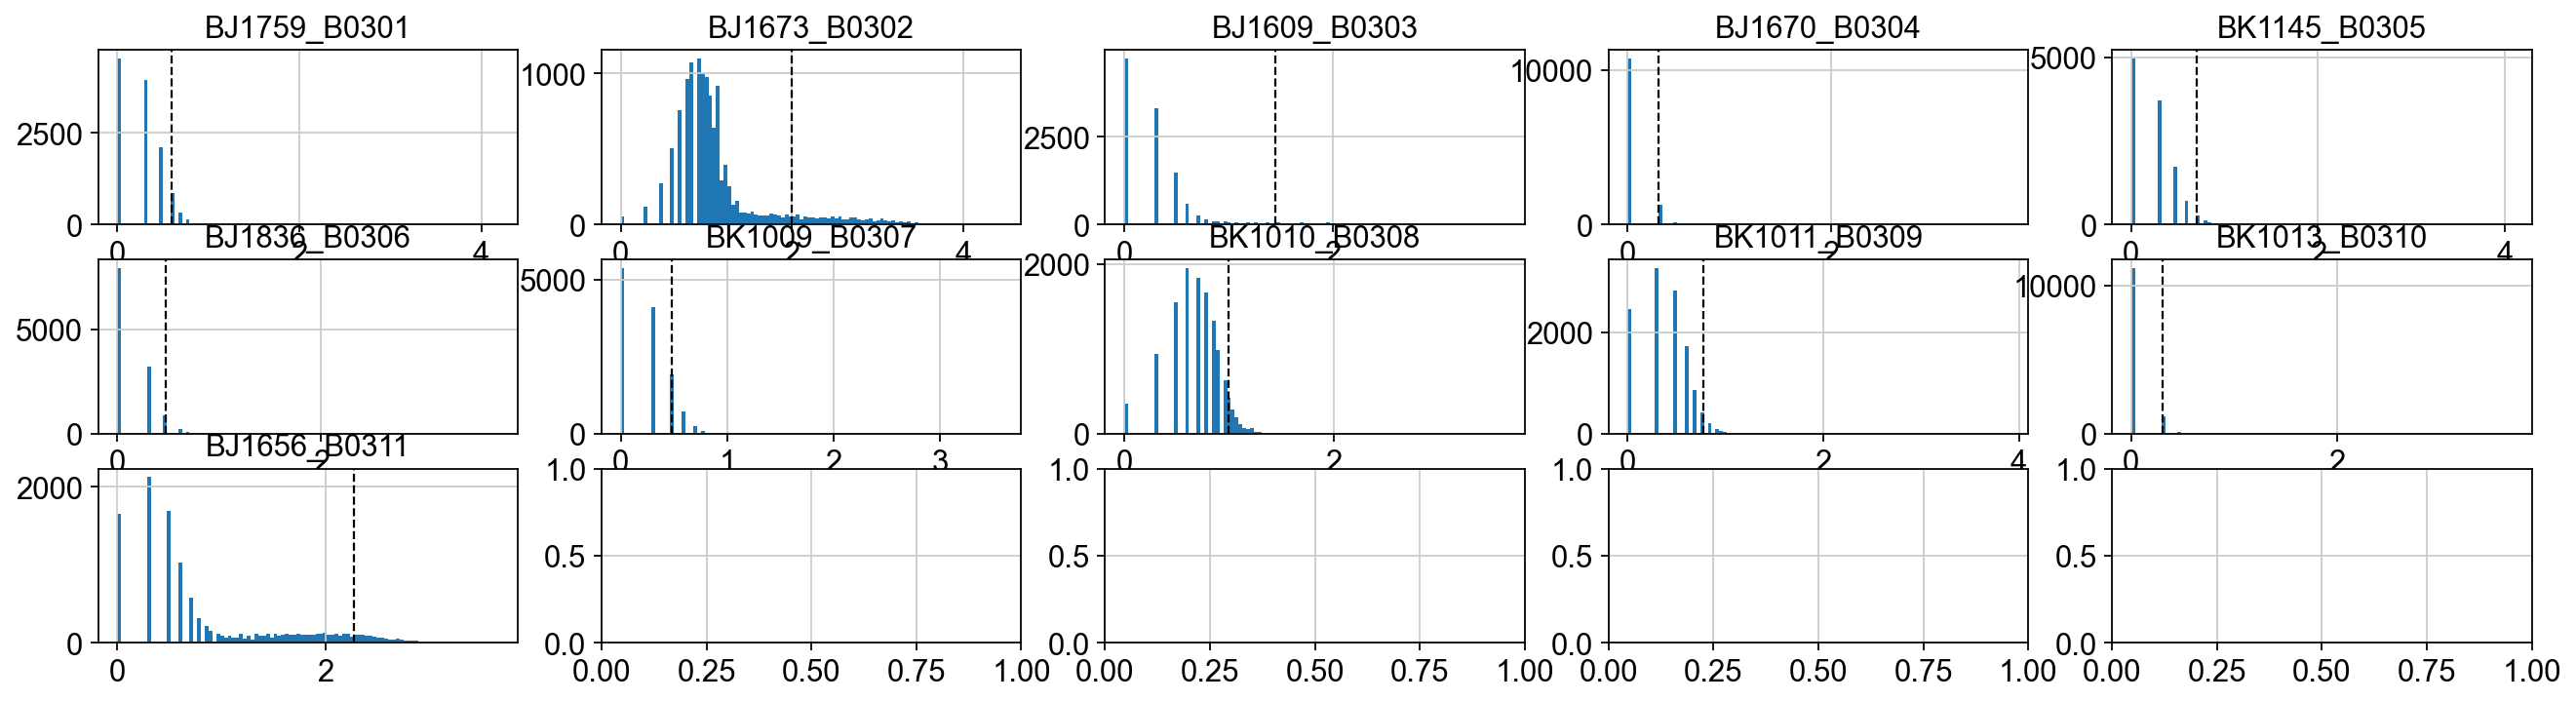

In [25]:
fig, axs = plt.subplots(3,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

plt.show()

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


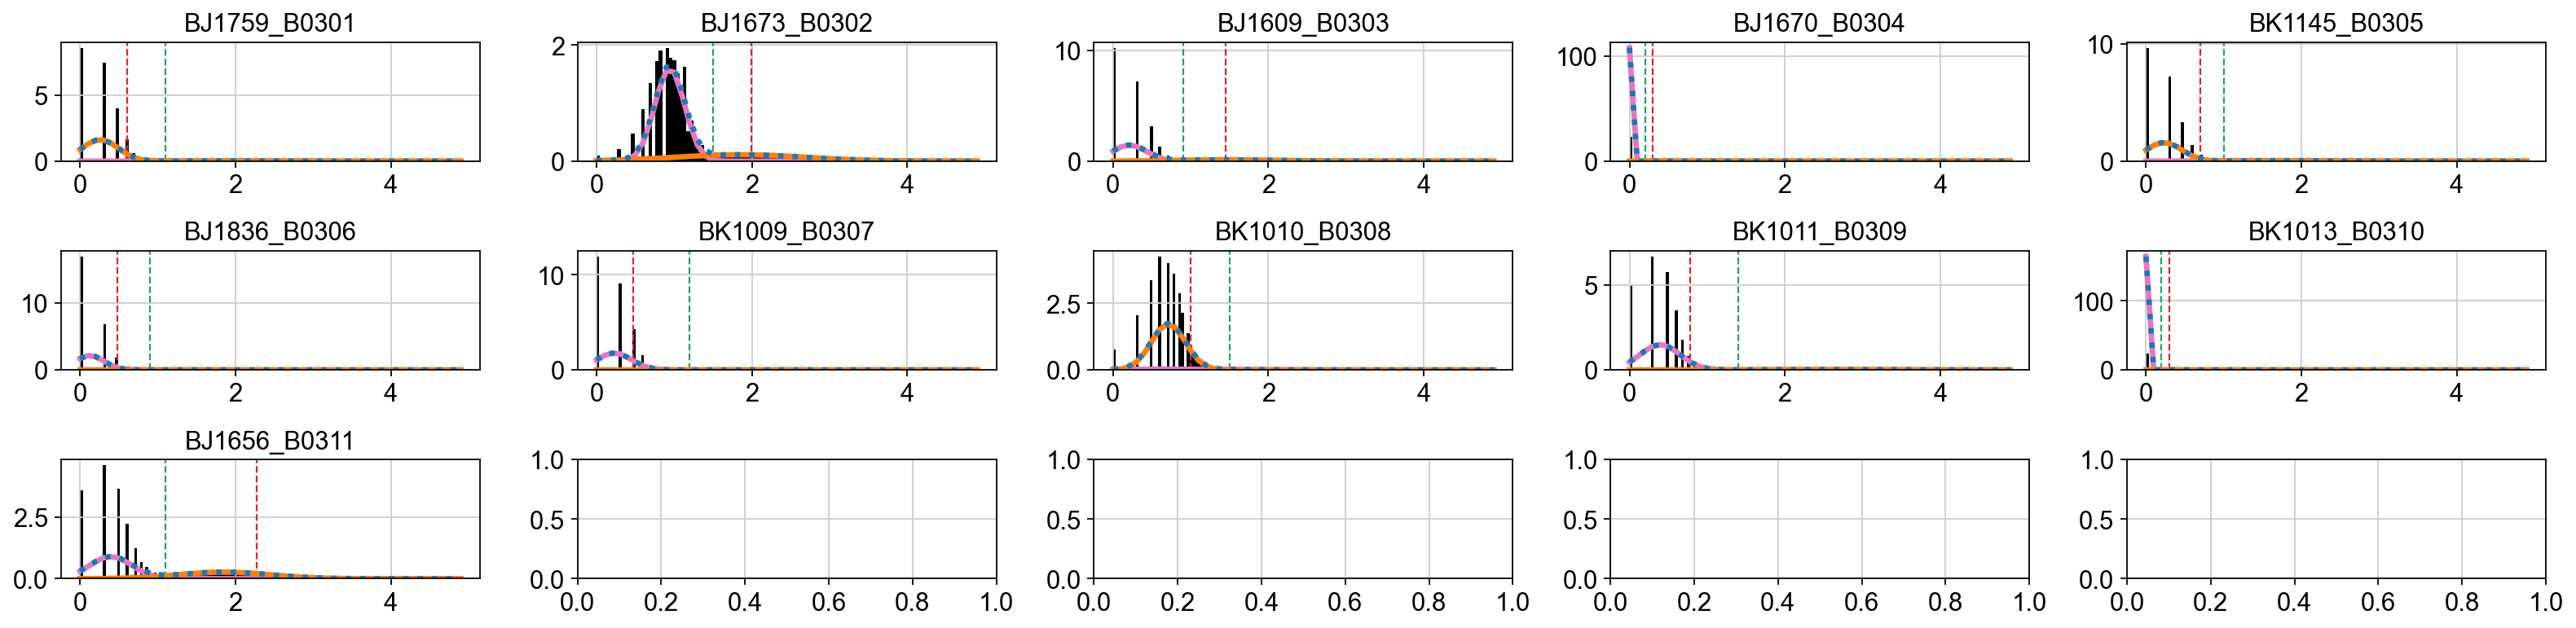

In [26]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(3,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

import pdb
for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False   
    #print(hashName)
    # fix text case where GMM is modeled to occur around a hash by counting the number of switches
    if mean[0][0] < mean[1][0] and (((y_axis1 < y_axis0)[0] == False and sum(v1 != v2 for v1, v2 in zip(y_axis1 < y_axis0, (y_axis1 < y_axis0)[1:])) % 2 == 0) or 
    sum(v1 != v2 for v1, v2 in zip(y_axis1 < y_axis0, (y_axis1 < y_axis0)[1:])) == 1):
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
plt.show()

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 0.5
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BJ1759_B0301
1.1
1.1
BJ1673_B0302
1.5
1.5
BJ1609_B0303
0.9
1.0
BJ1670_B0304
0.2
1.0
BK1145_B0305
1.0
1.0
BJ1836_B0306
0.9
1.0
BK1009_B0307
1.2000000000000002
1.2000000000000002
BK1010_B0308
1.5
1.5
BK1011_B0309
1.4000000000000001
1.4000000000000001
BK1013_B0310
0.2
1.0
BJ1656_B0311
1.1
1.1


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/2992827765.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/2992827765.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ...  True False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/2992827765.py:11: FutureWarning: Setting an item of inc

In [28]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1

In [29]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BJ1656_B0311    3906
negative        2721
BJ1673_B0302    1599
BJ1609_B0303    1481
doublet          901
BK1145_B0305     680
BJ1759_B0301     441
BK1011_B0309     413
BJ1670_B0304     216
BJ1836_B0306     101
BK1010_B0308      59
BK1009_B0307      57
BK1013_B0310      39
Name: count, dtype: int64

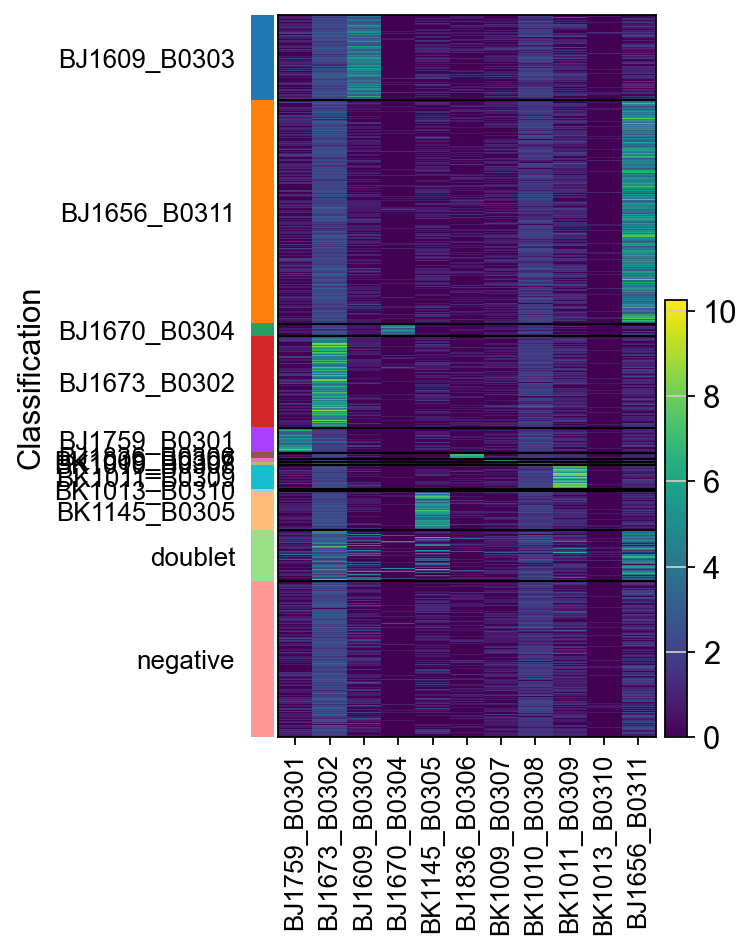

In [30]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set highly variable genes before moving all mean to 0

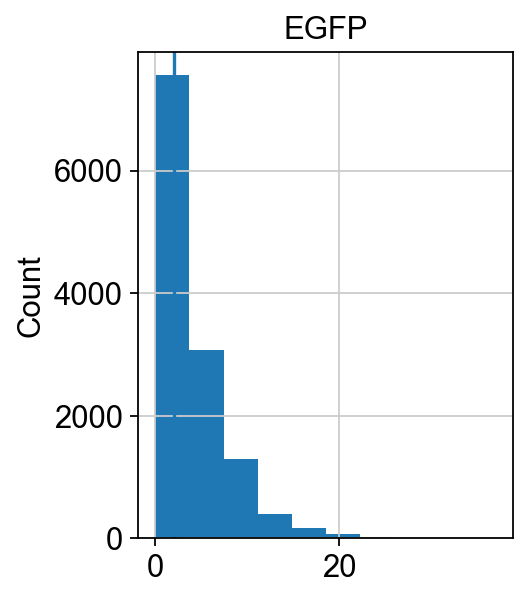

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

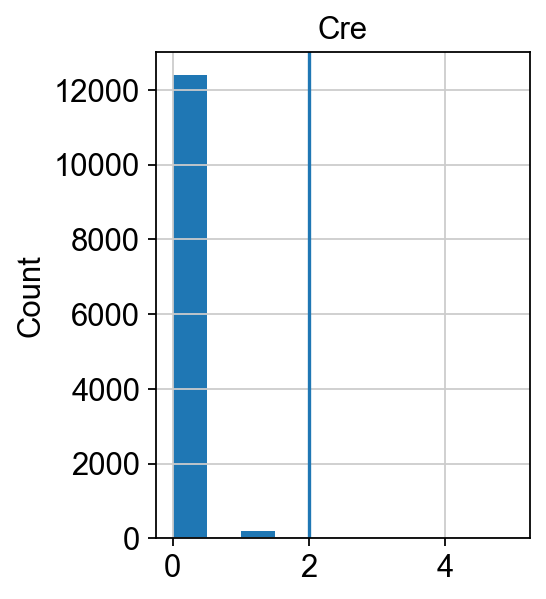

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [34]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

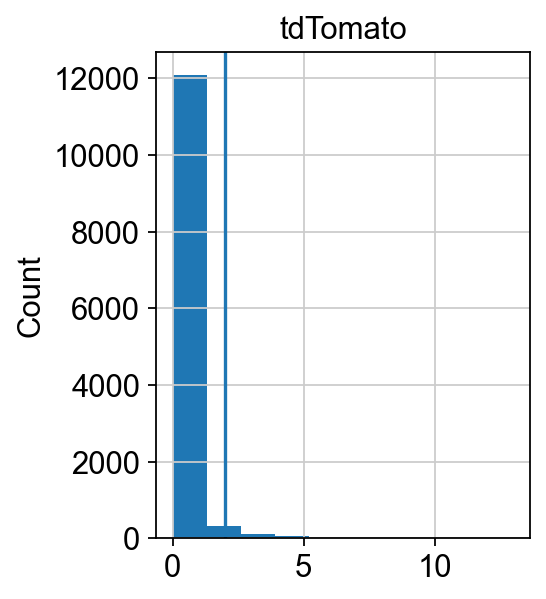

In [35]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [36]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [37]:
adata.obs.Classification.value_counts()

Classification
BJ1656_B0311    3906
negative        2721
BJ1673_B0302    1599
BJ1609_B0303    1481
doublet          901
BK1145_B0305     680
BJ1759_B0301     441
BK1011_B0309     413
BJ1670_B0304     216
BJ1836_B0306     101
BK1010_B0308      59
BK1009_B0307      57
BK1013_B0310      39
Name: count, dtype: int64

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
BJ1656_B0311    3906
BJ1673_B0302    1599
BJ1609_B0303    1481
BK1145_B0305     680
BJ1759_B0301     441
BK1011_B0309     413
BJ1670_B0304     216
BJ1836_B0306     101
BK1010_B0308      59
BK1009_B0307      57
BK1013_B0310      39
Name: count, dtype: int64

## Set Groups

In [40]:
samples

['BJ1759_B0301',
 'BJ1673_B0302',
 'BJ1609_B0303',
 'BJ1670_B0304',
 'BK1145_B0305',
 'BJ1836_B0306',
 'BK1009_B0307',
 'BK1010_B0308',
 'BK1011_B0309',
 'BK1013_B0310',
 'BJ1656_B0311']

In [41]:
#Set groups
adata.obs['Group'] = 'MRTX1133'
adata.obs['Group'][adata.obs.Classification.isin(['BJ1759_B0301','BJ1673_B0302'])] = 'Saline'
adata.obs['Group'][adata.obs.Classification.isin(['BJ1609_B0303','BJ1670_B0304','BK1145_B0305'])] = 'Cisplatin'
adata.obs['Group'][adata.obs.Classification.isin(['BJ1656_B0311'])] = 'untreated'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/1315781620.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'MRTX1133'
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/1315781620.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: 

In [42]:
# Remove carrier KP mouse cells
adata = adata[~adata.obs['Group'].isin(['untreated']),:]

In [43]:
adata.obs.Group.value_counts()

Group
Cisplatin    2377
Saline       2040
MRTX1133      669
Name: count, dtype: int64

## Basic Processing of Data

In [44]:
adata.layers['counts']=adata.X.copy()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [46]:
sc.pp.log1p(adata)

In [47]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


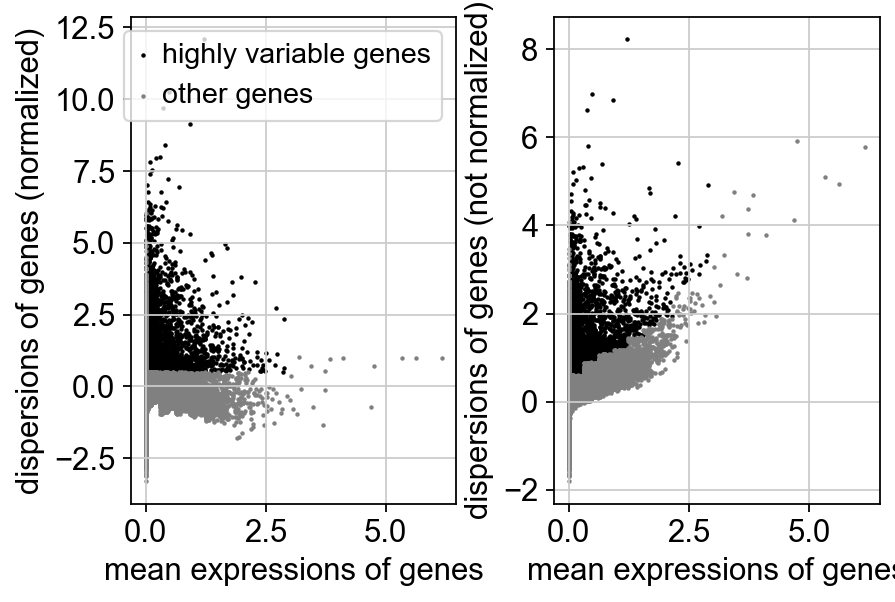

In [48]:
sc.pl.highly_variable_genes(adata)

In [49]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/1996744496.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/199674

In [50]:
adata.raw = adata

In [51]:
adata.write('write/allmice-IGO16562.h5ad', compression='gzip')

In [52]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Principal component analysis

In [53]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:01)


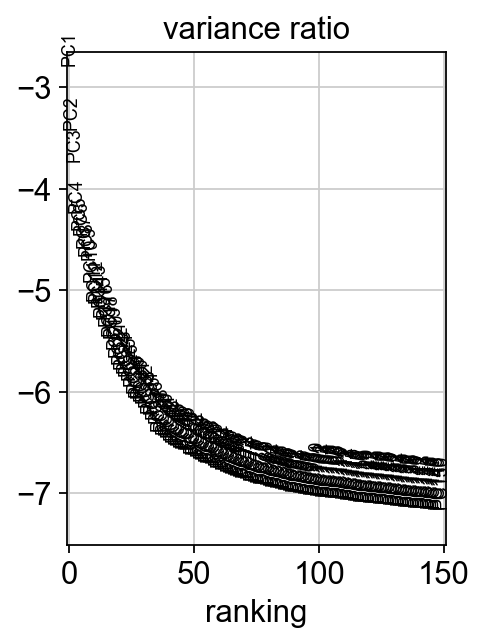

In [54]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [55]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [56]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=80)

computing neighbors
    using 'X_pca' with n_pcs = 80
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [57]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


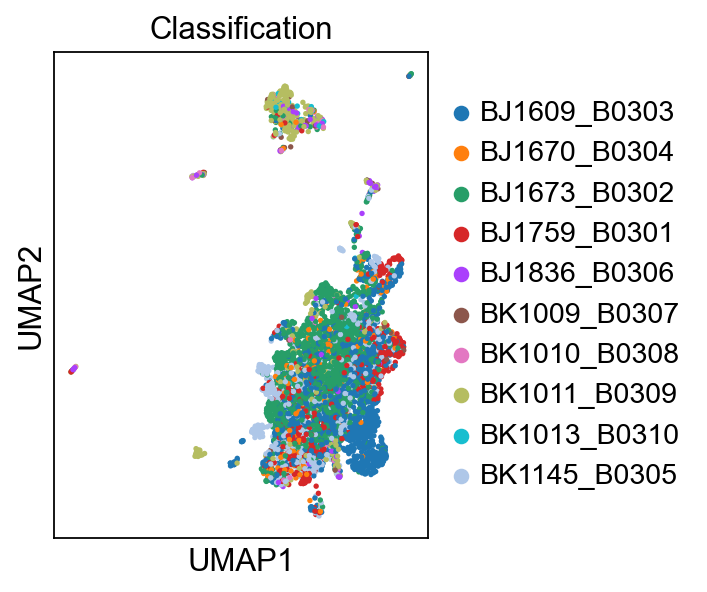

In [58]:
sc.pl.umap(adata, color=['Classification'])

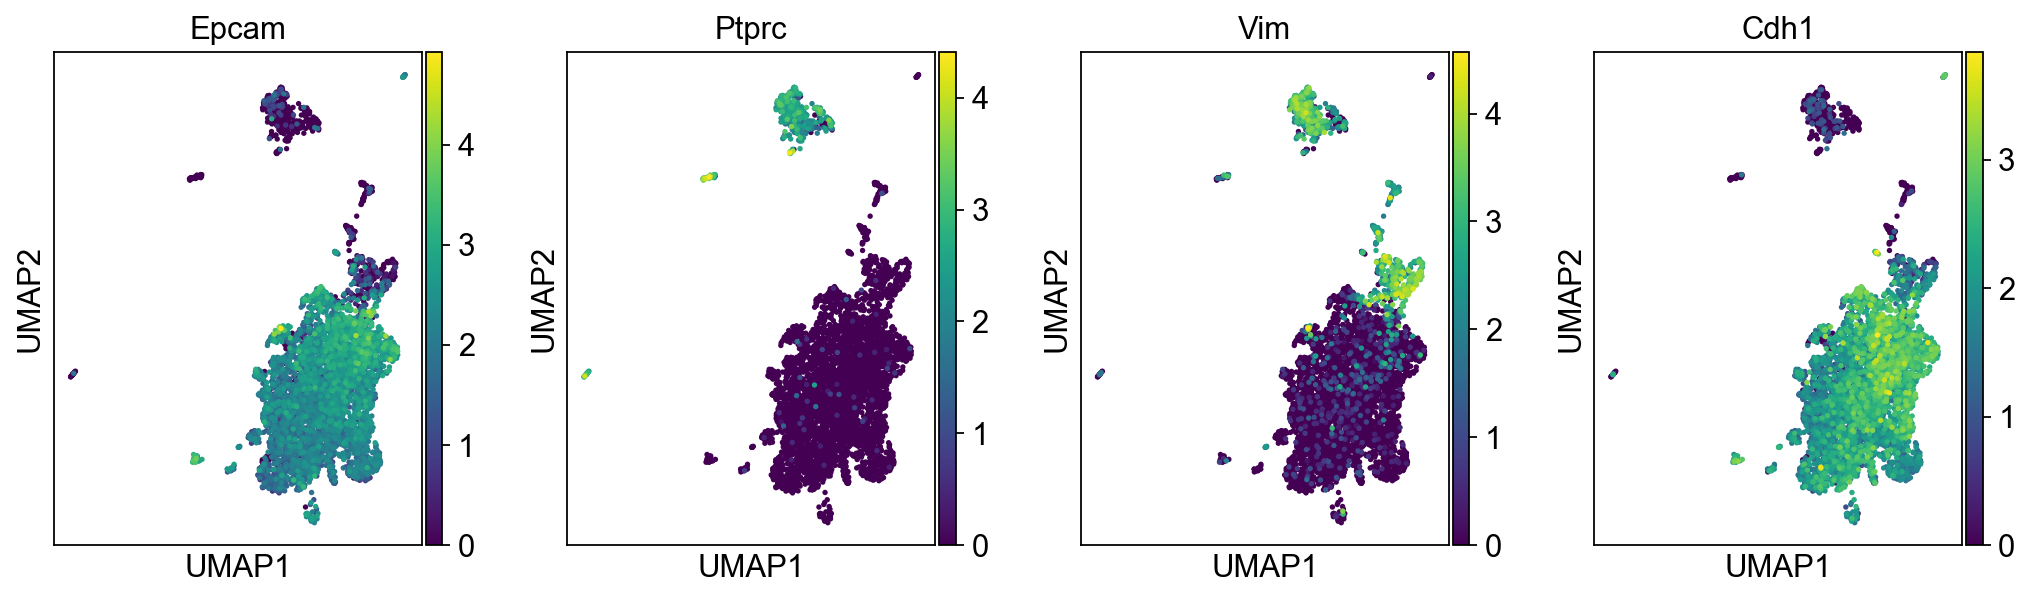

In [59]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

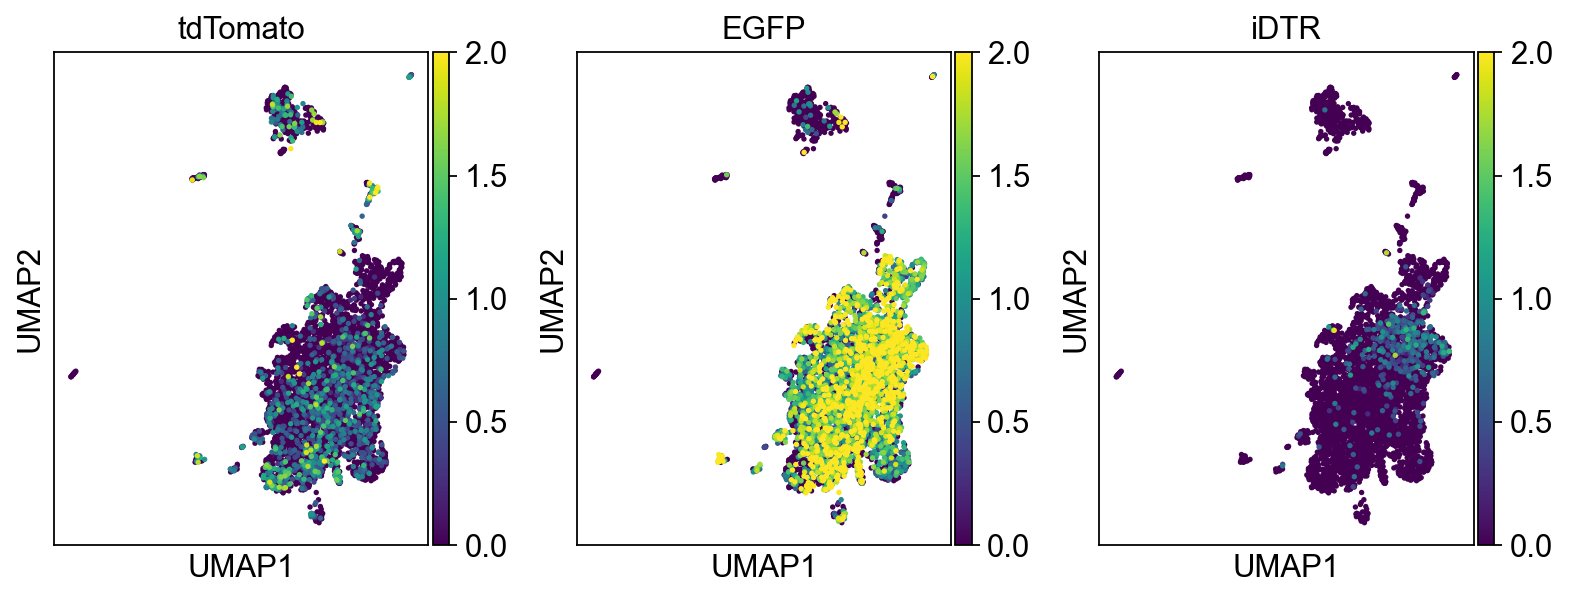

In [60]:
sc.pl.umap(adata, color=['tdTomato','EGFP','iDTR'], vmax=2) #,'mScarlet'

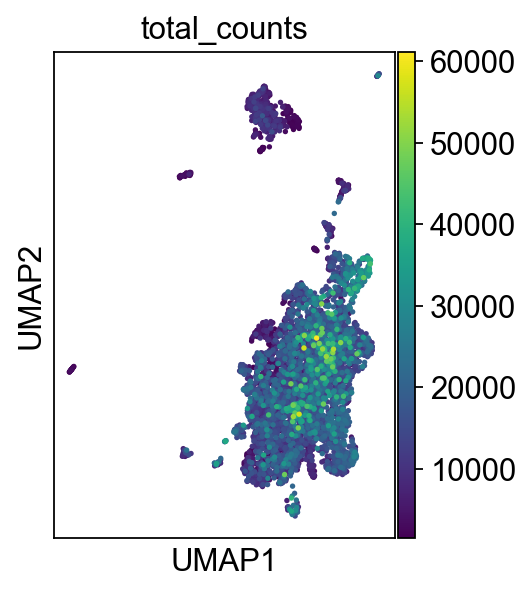

In [61]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [62]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [63]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [64]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1395 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1291 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1397 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1595 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1590 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Rps2-ps6', 'Fam46c', 'Gm6139'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2089 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', sco

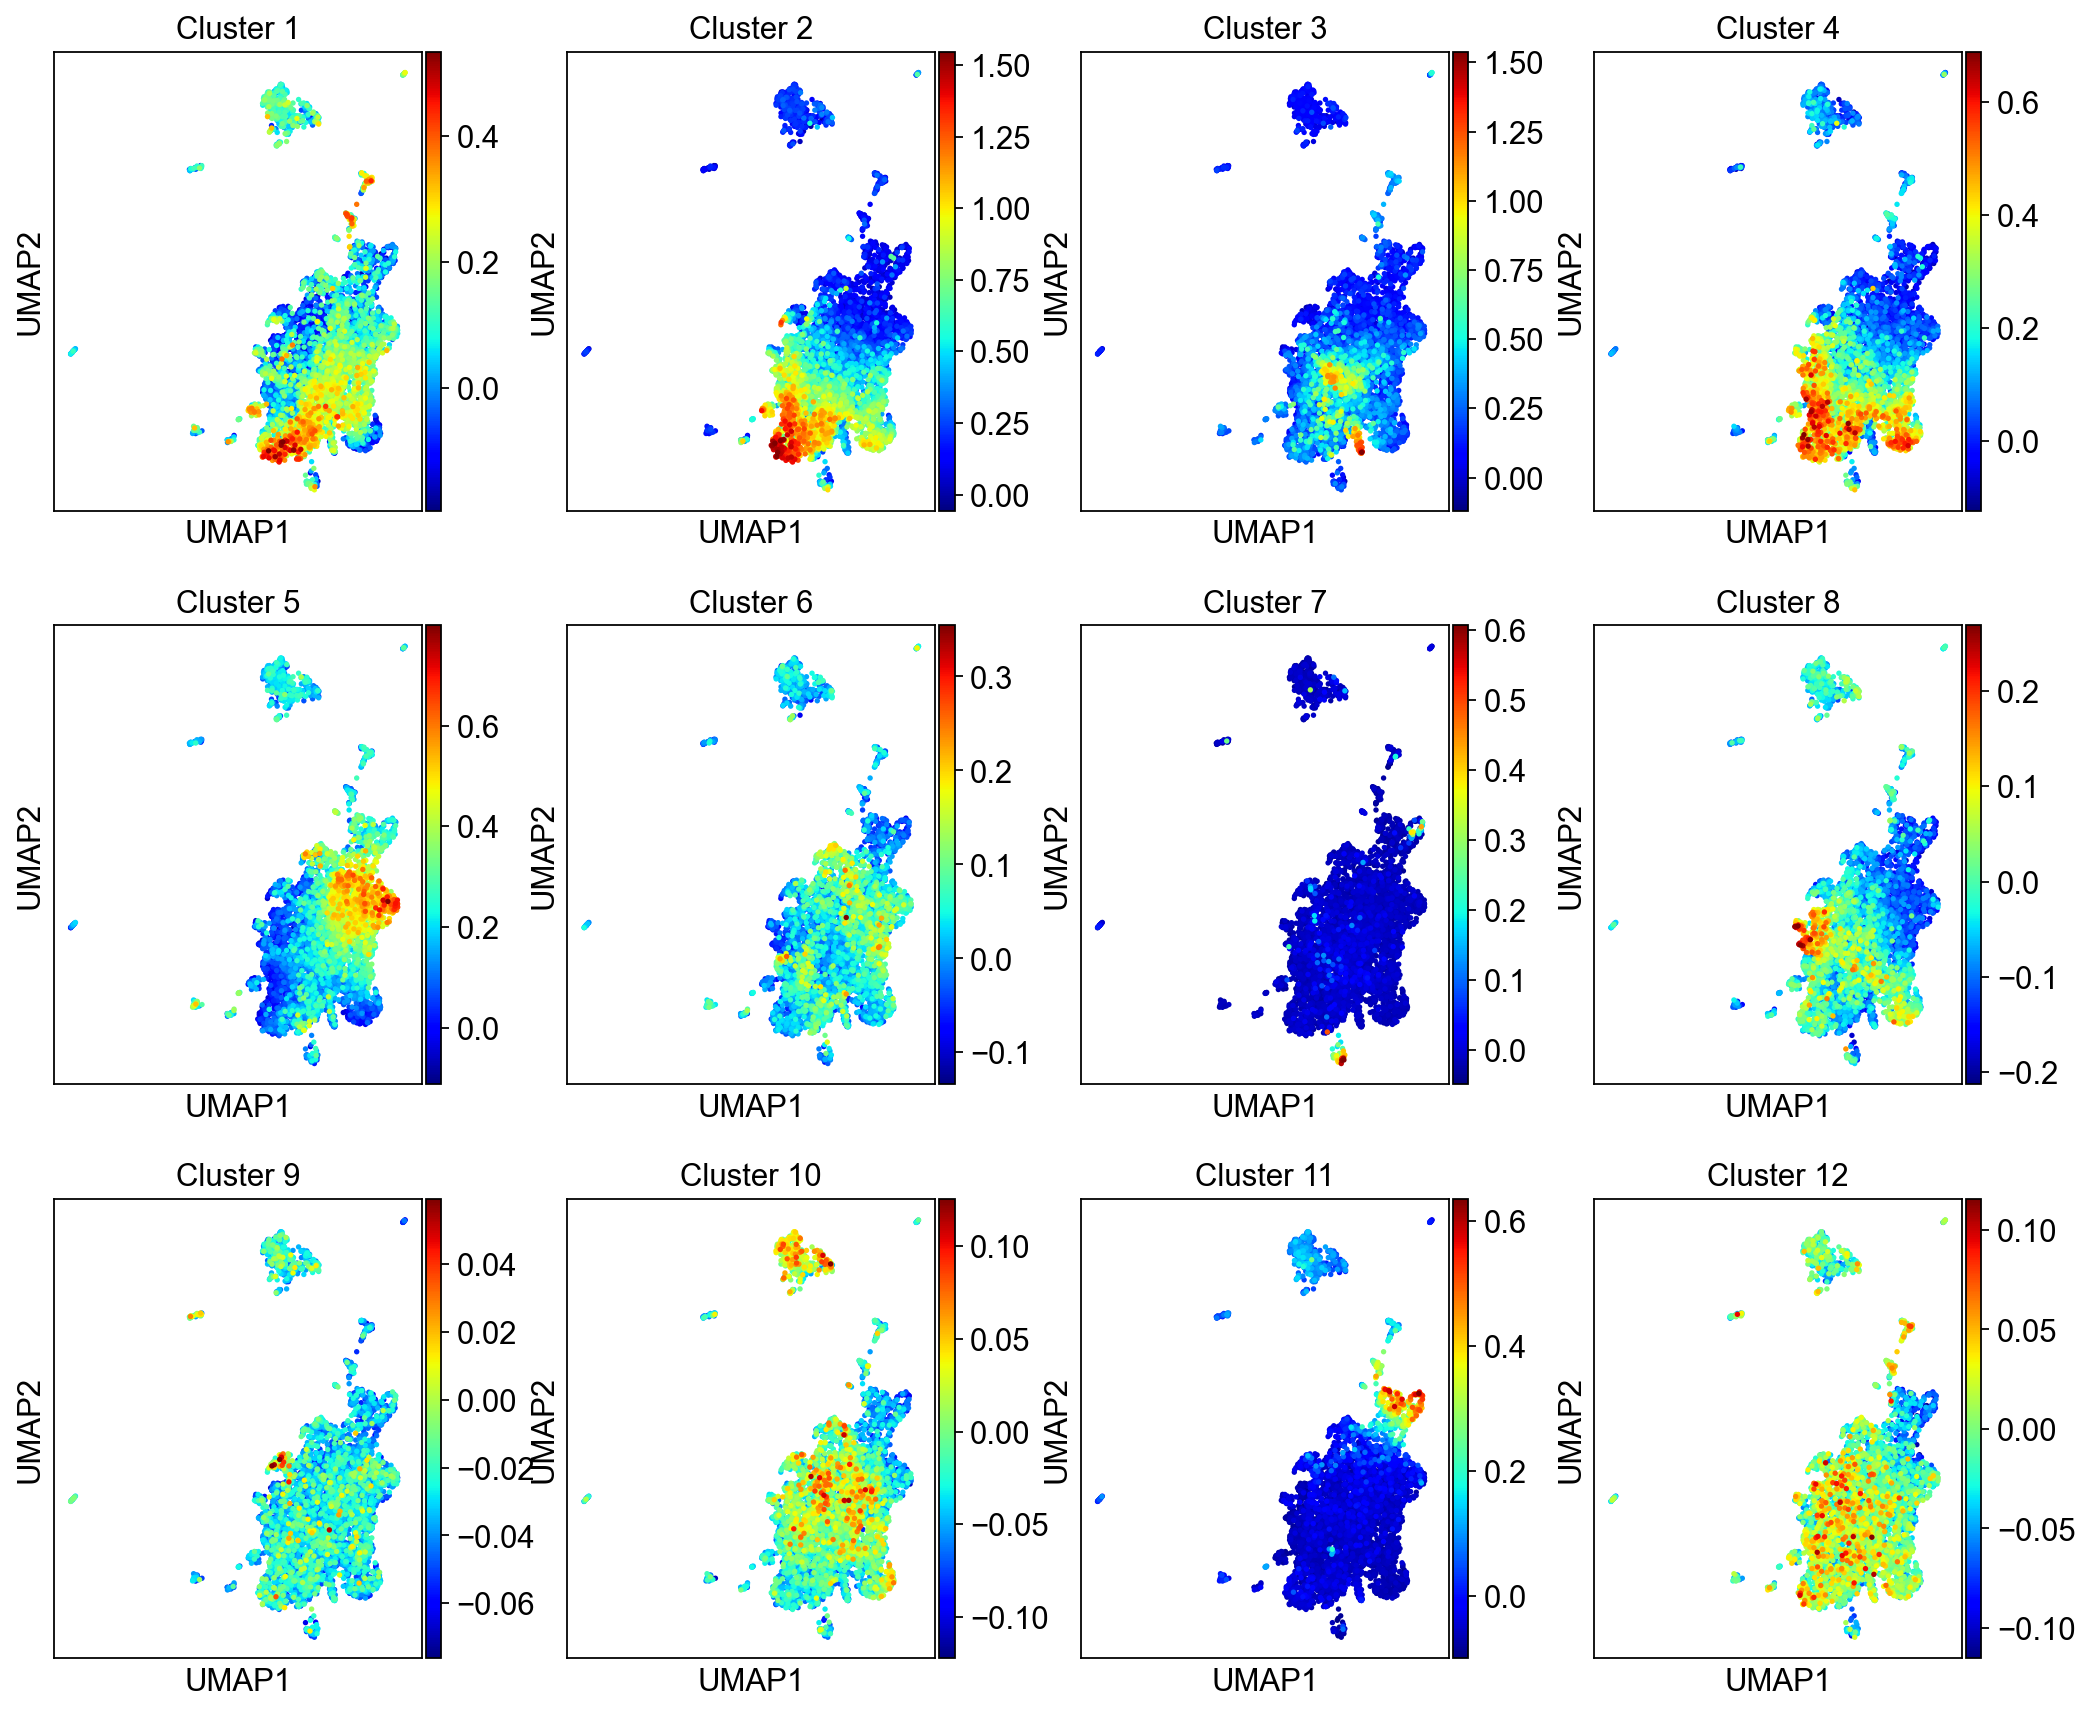

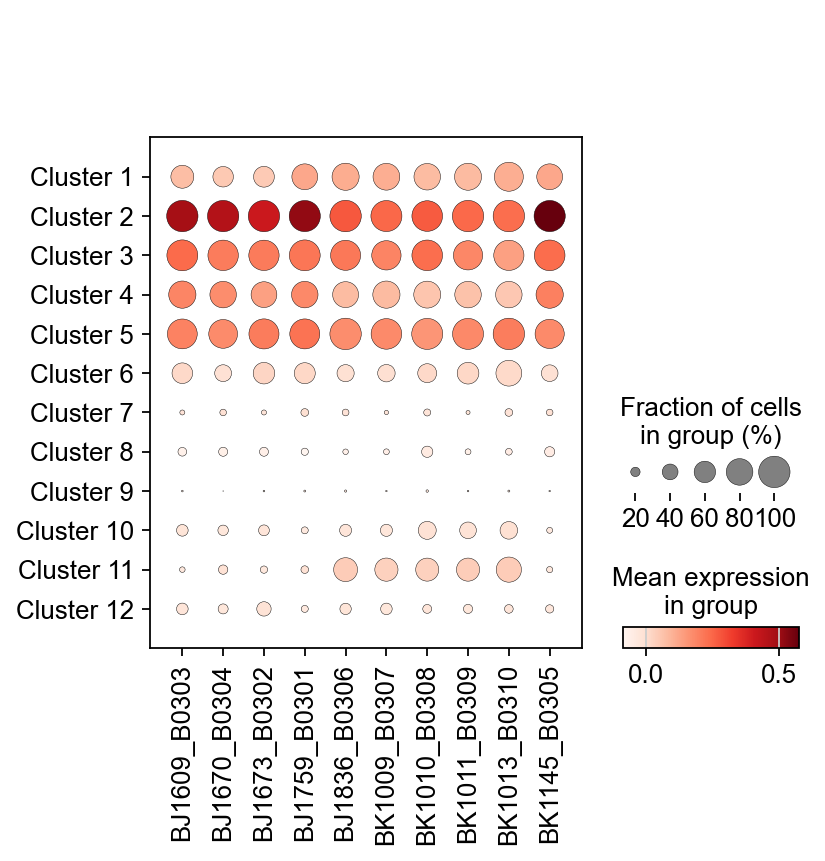

In [65]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [66]:
#sc.tl.leiden(adata, resolution=0.2)
sc.tl.leiden(adata, resolution=0.35)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/2369545210.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.35)


    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


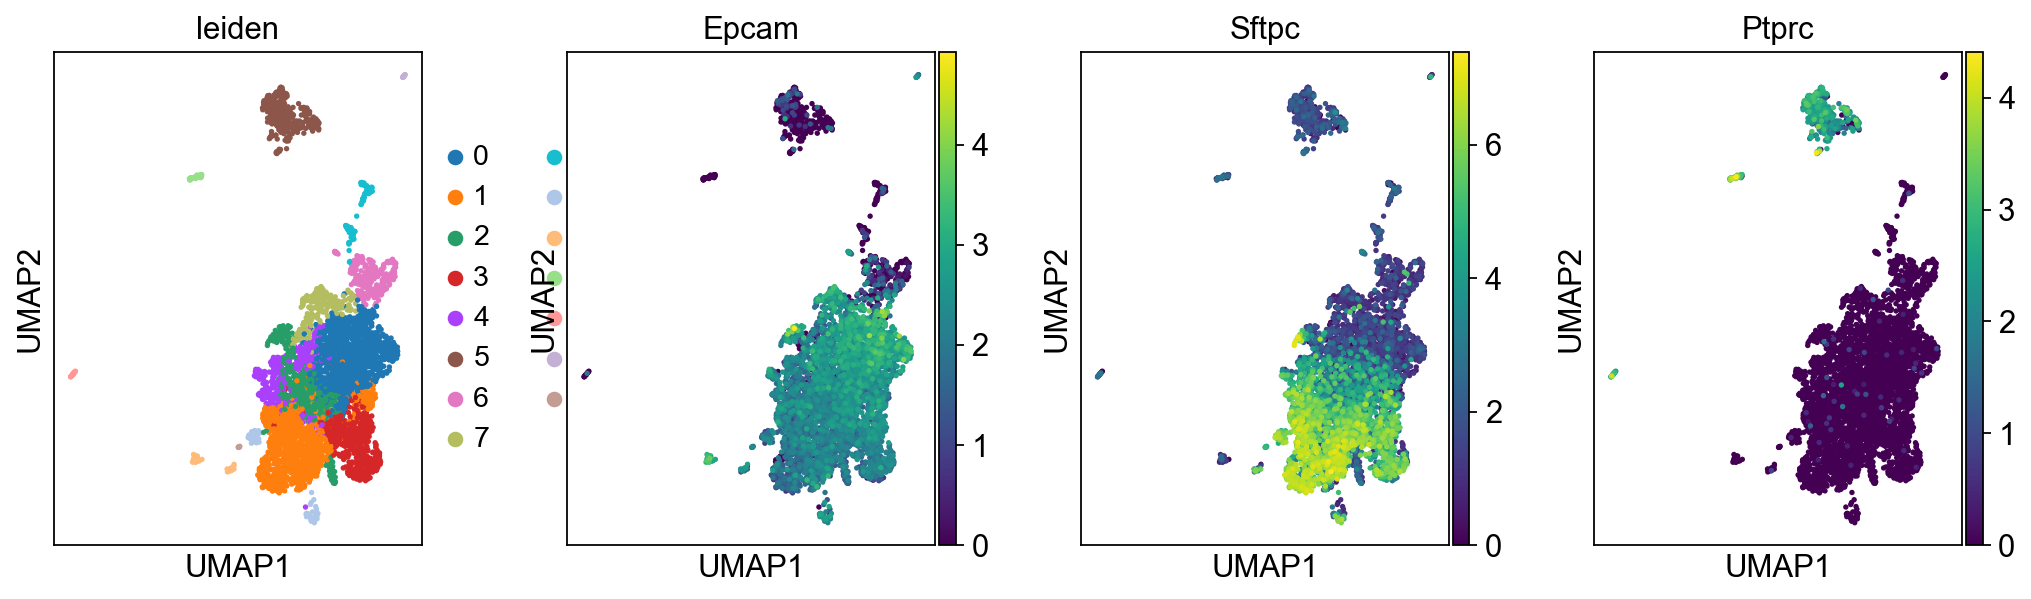

(None,)

In [67]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

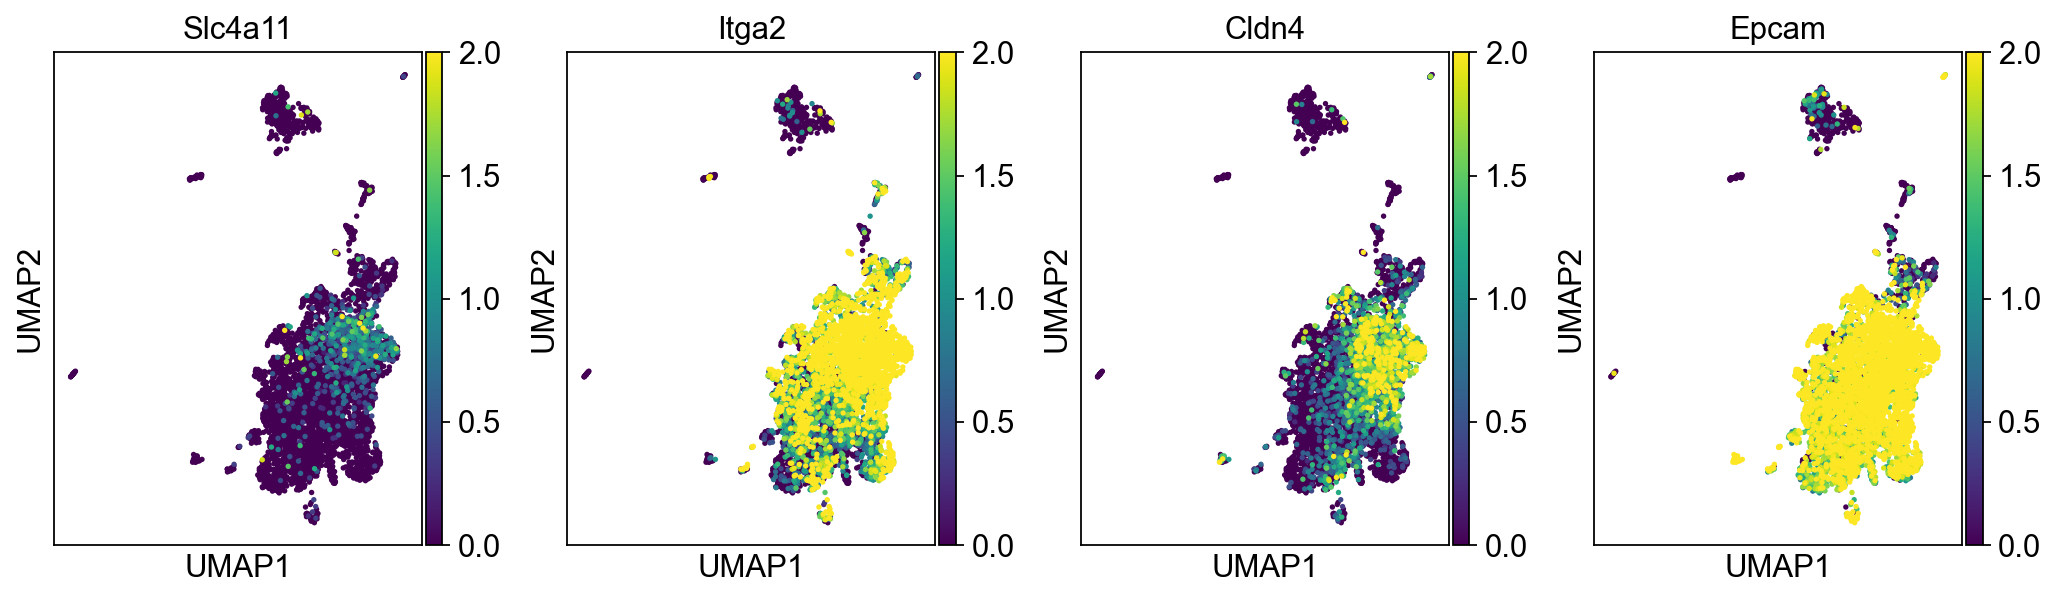

In [68]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

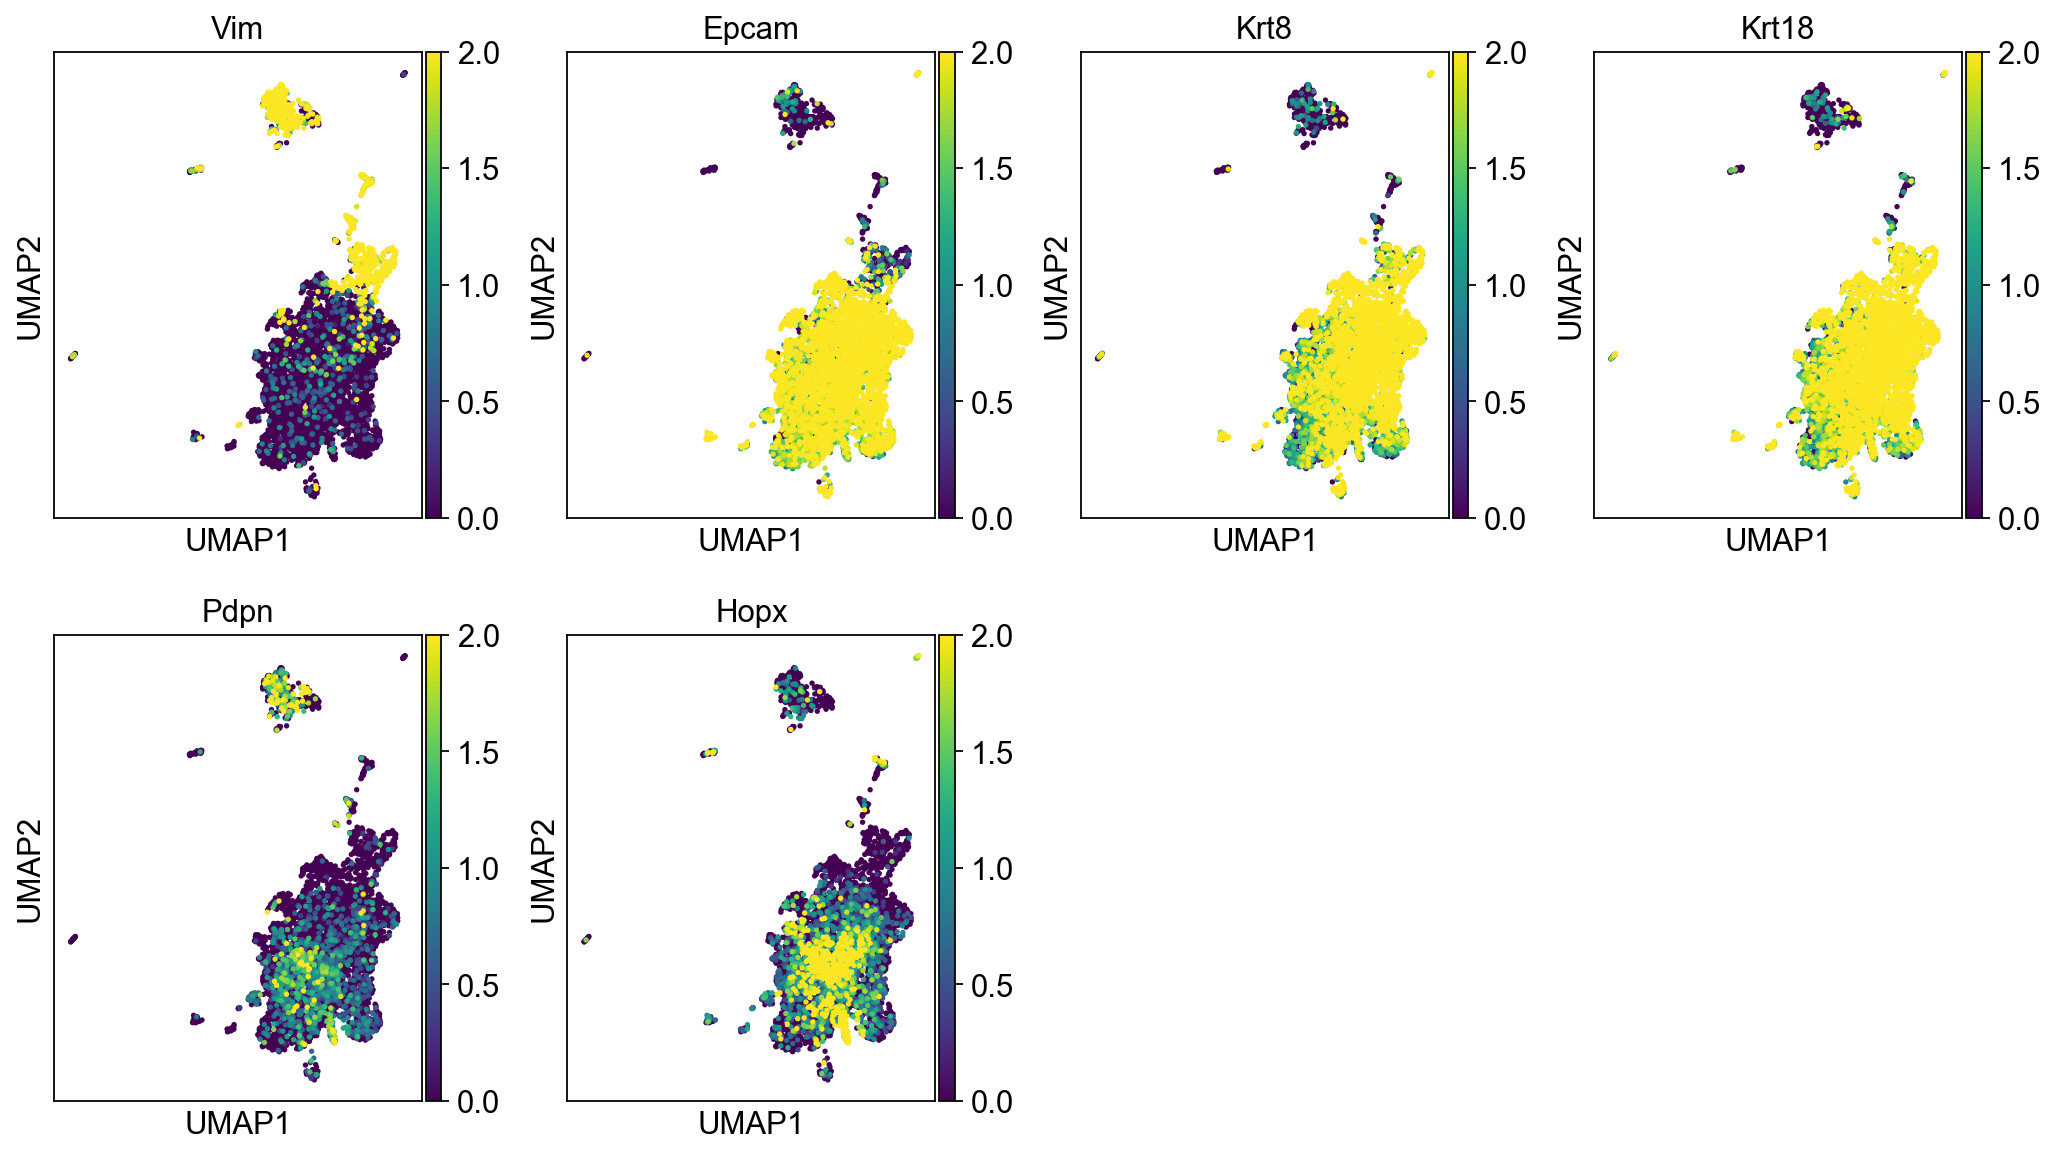

In [69]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

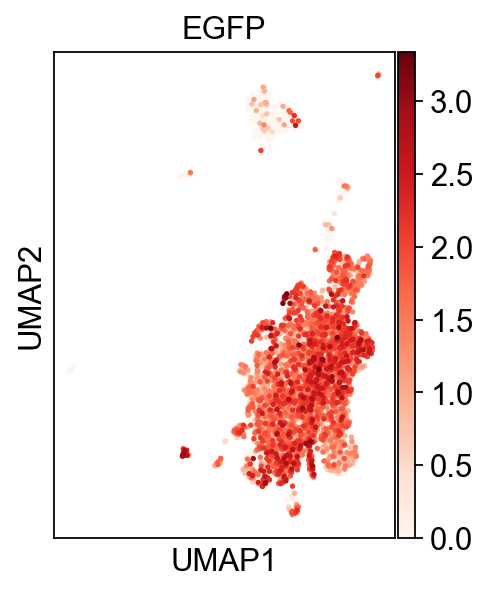

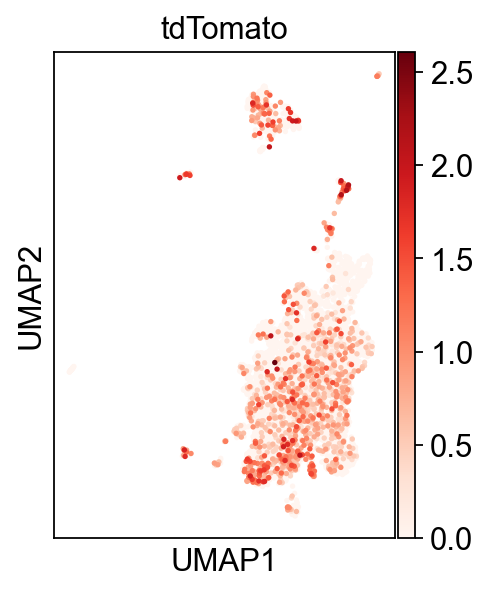

In [70]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

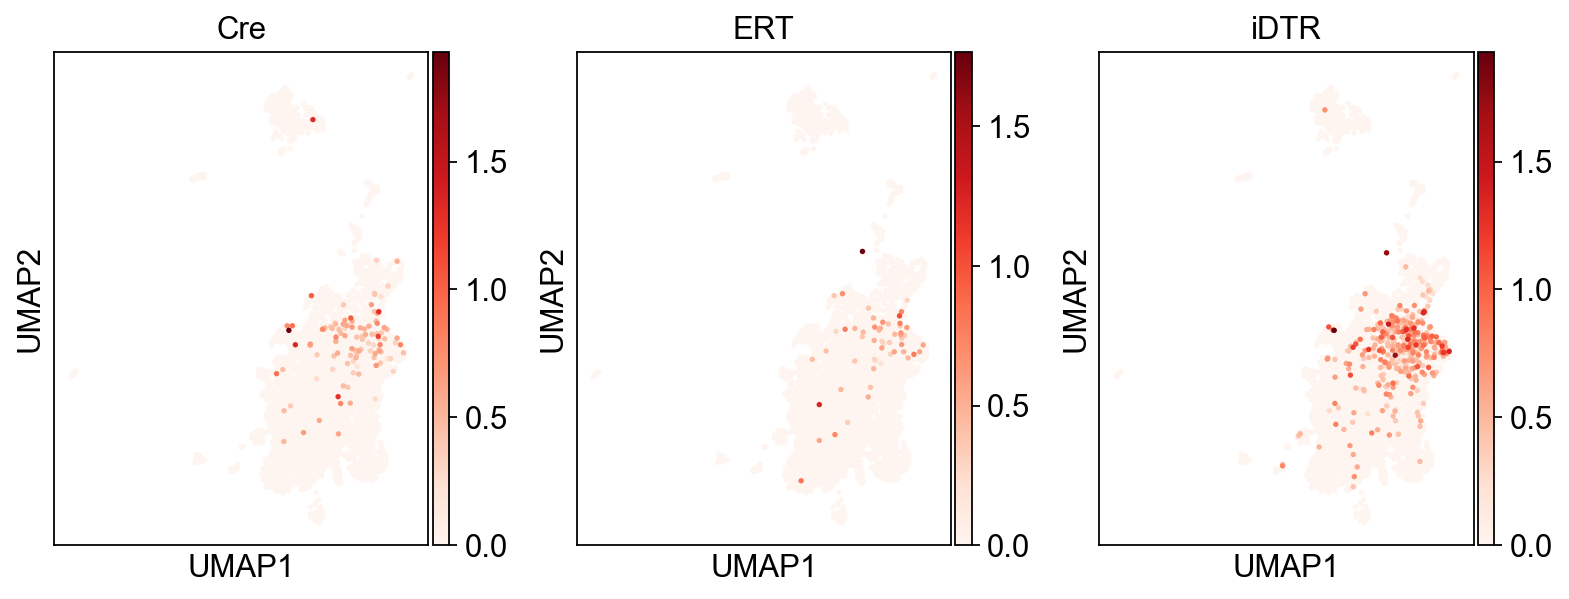

In [71]:
sc.pl.umap(adata, color=["Cre", "ERT",'iDTR'], cmap='Reds') #"mScarlet", 

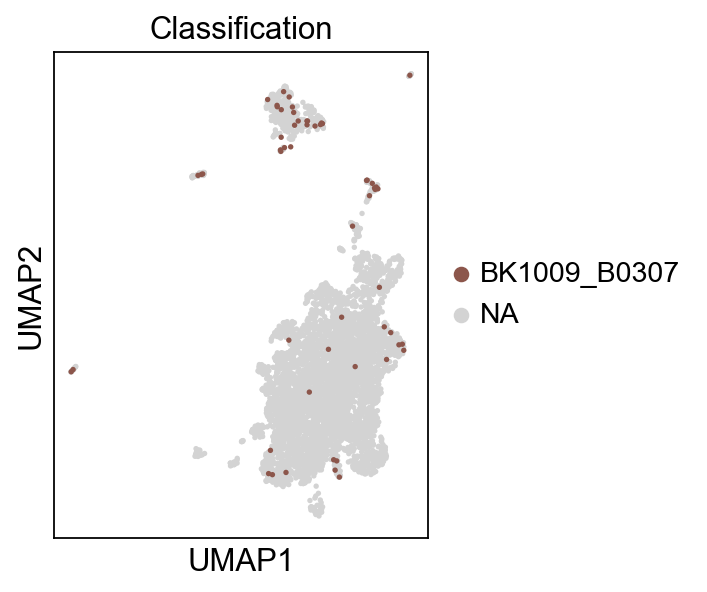

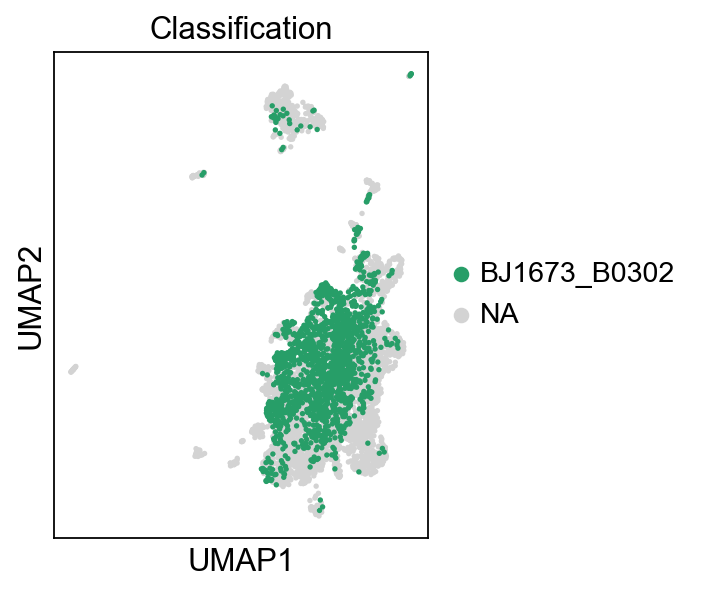

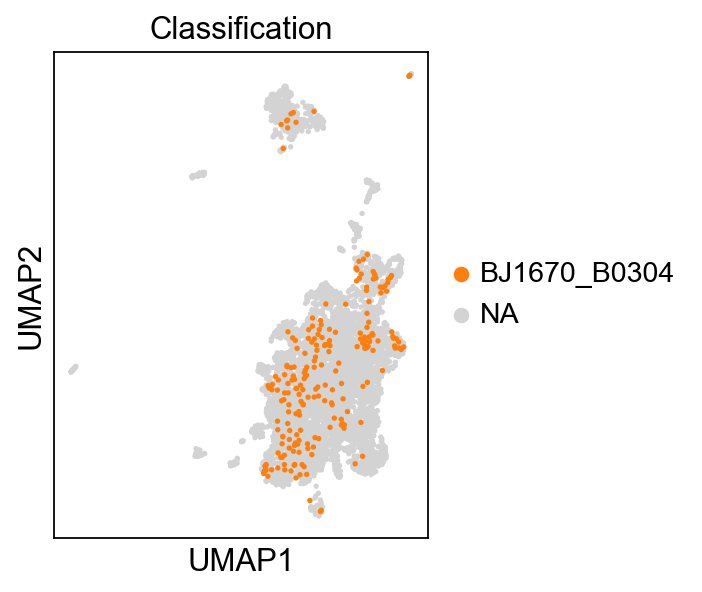

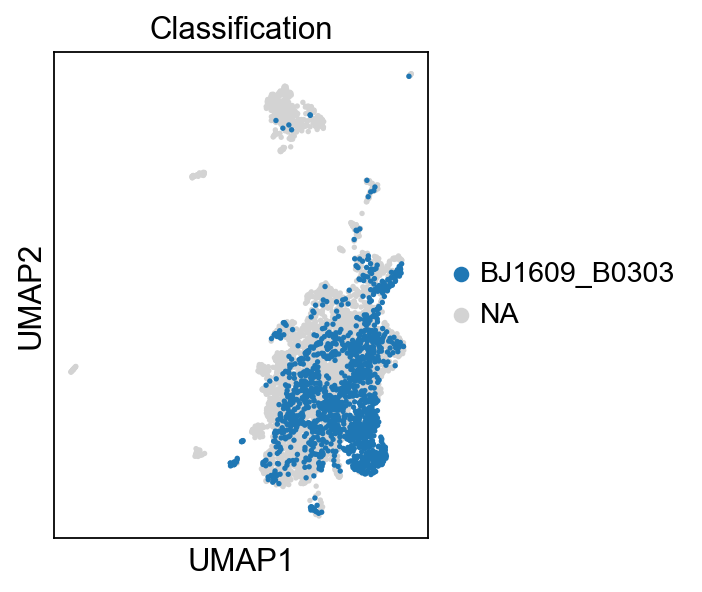

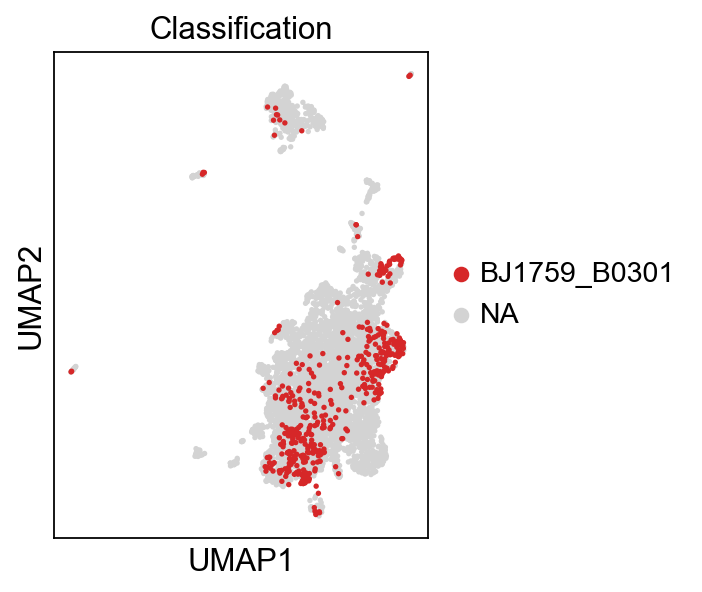

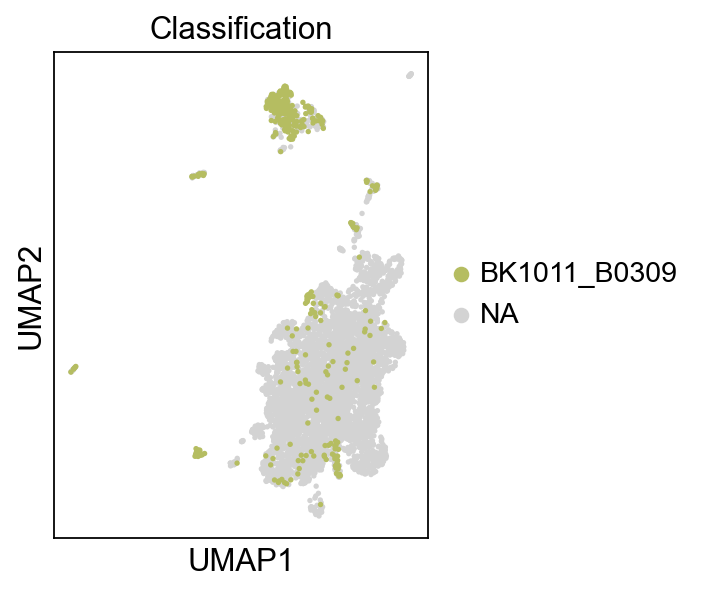

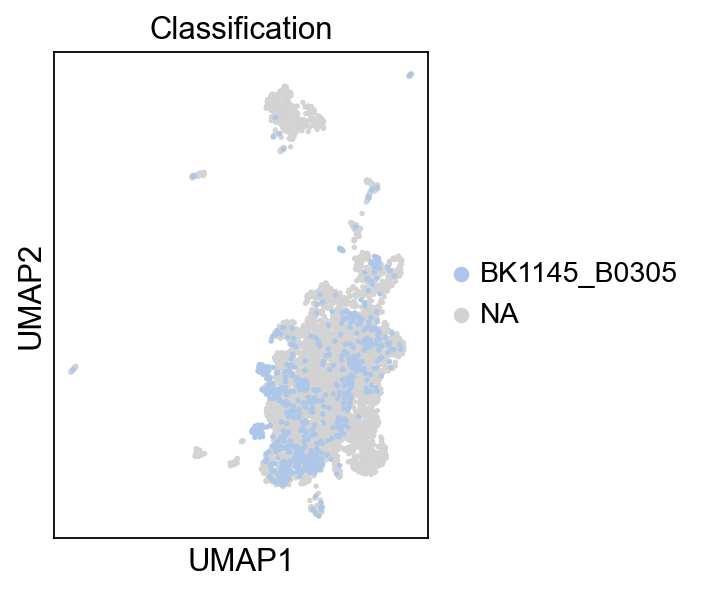

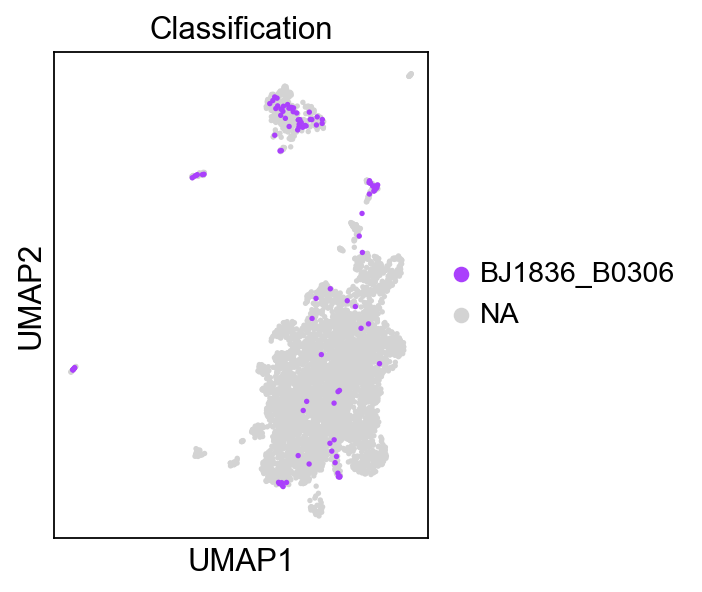

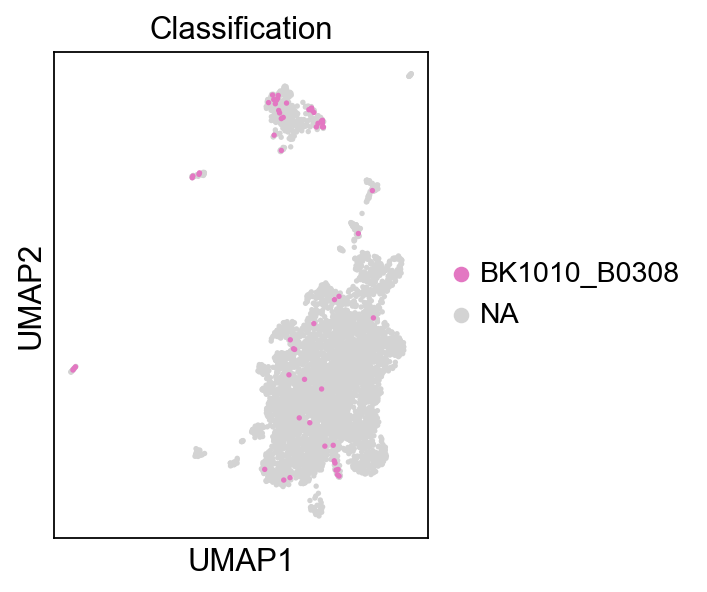

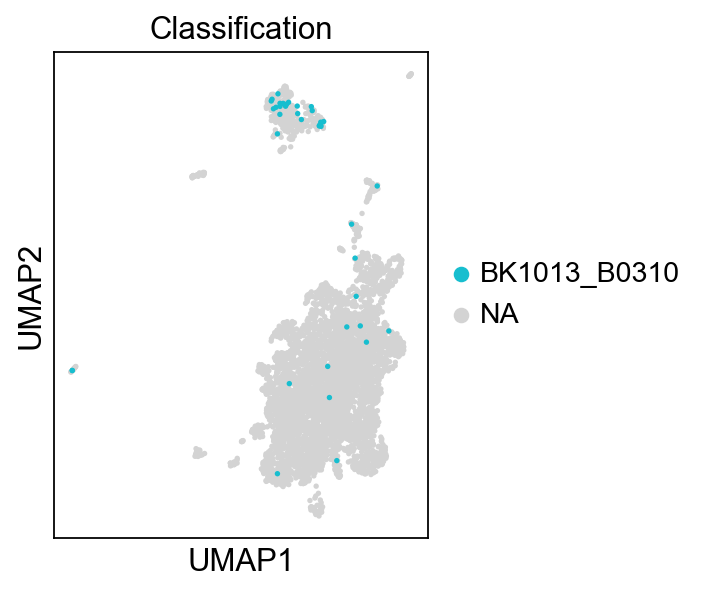

In [72]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

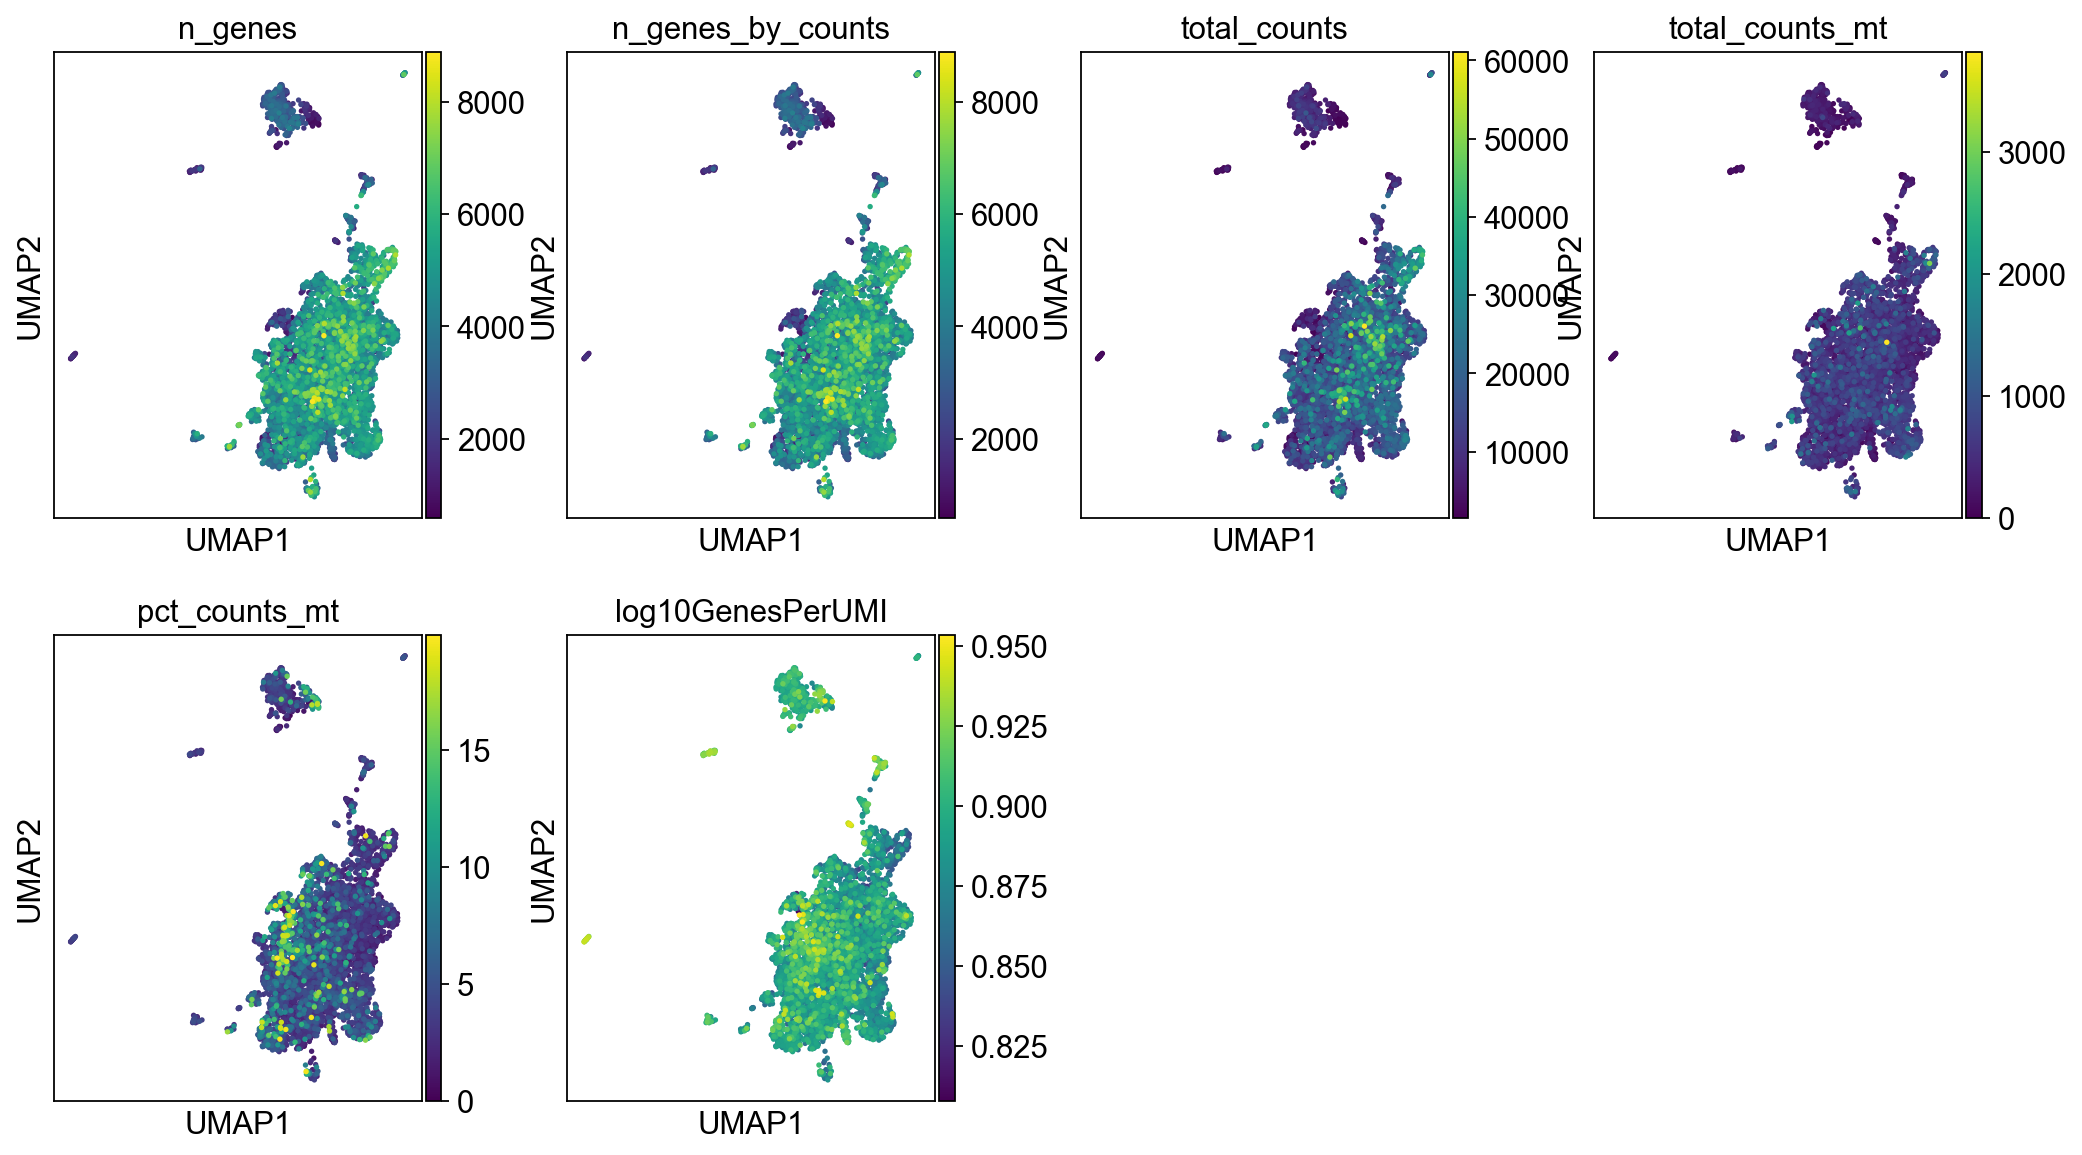

In [73]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

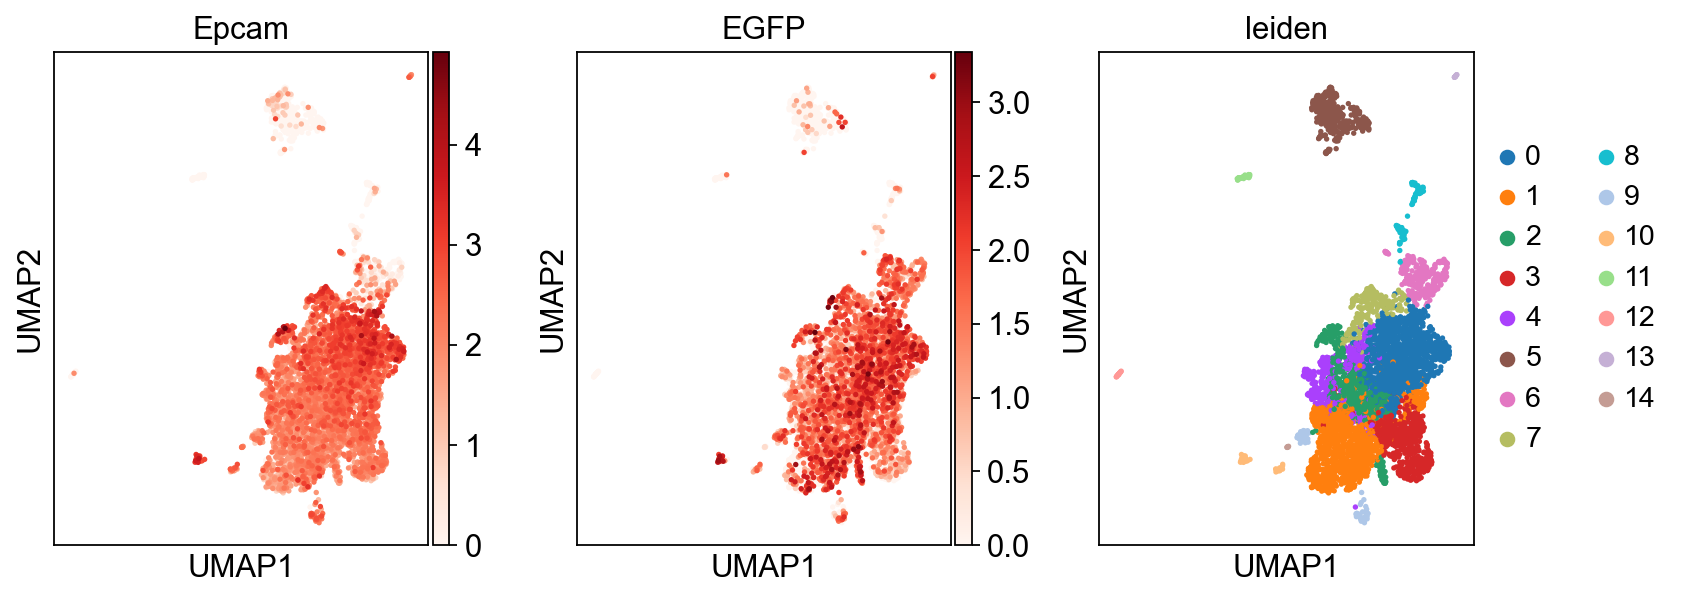

In [74]:
sc.pl.umap(adata, color=['Epcam','EGFP','leiden'],cmap="Reds")

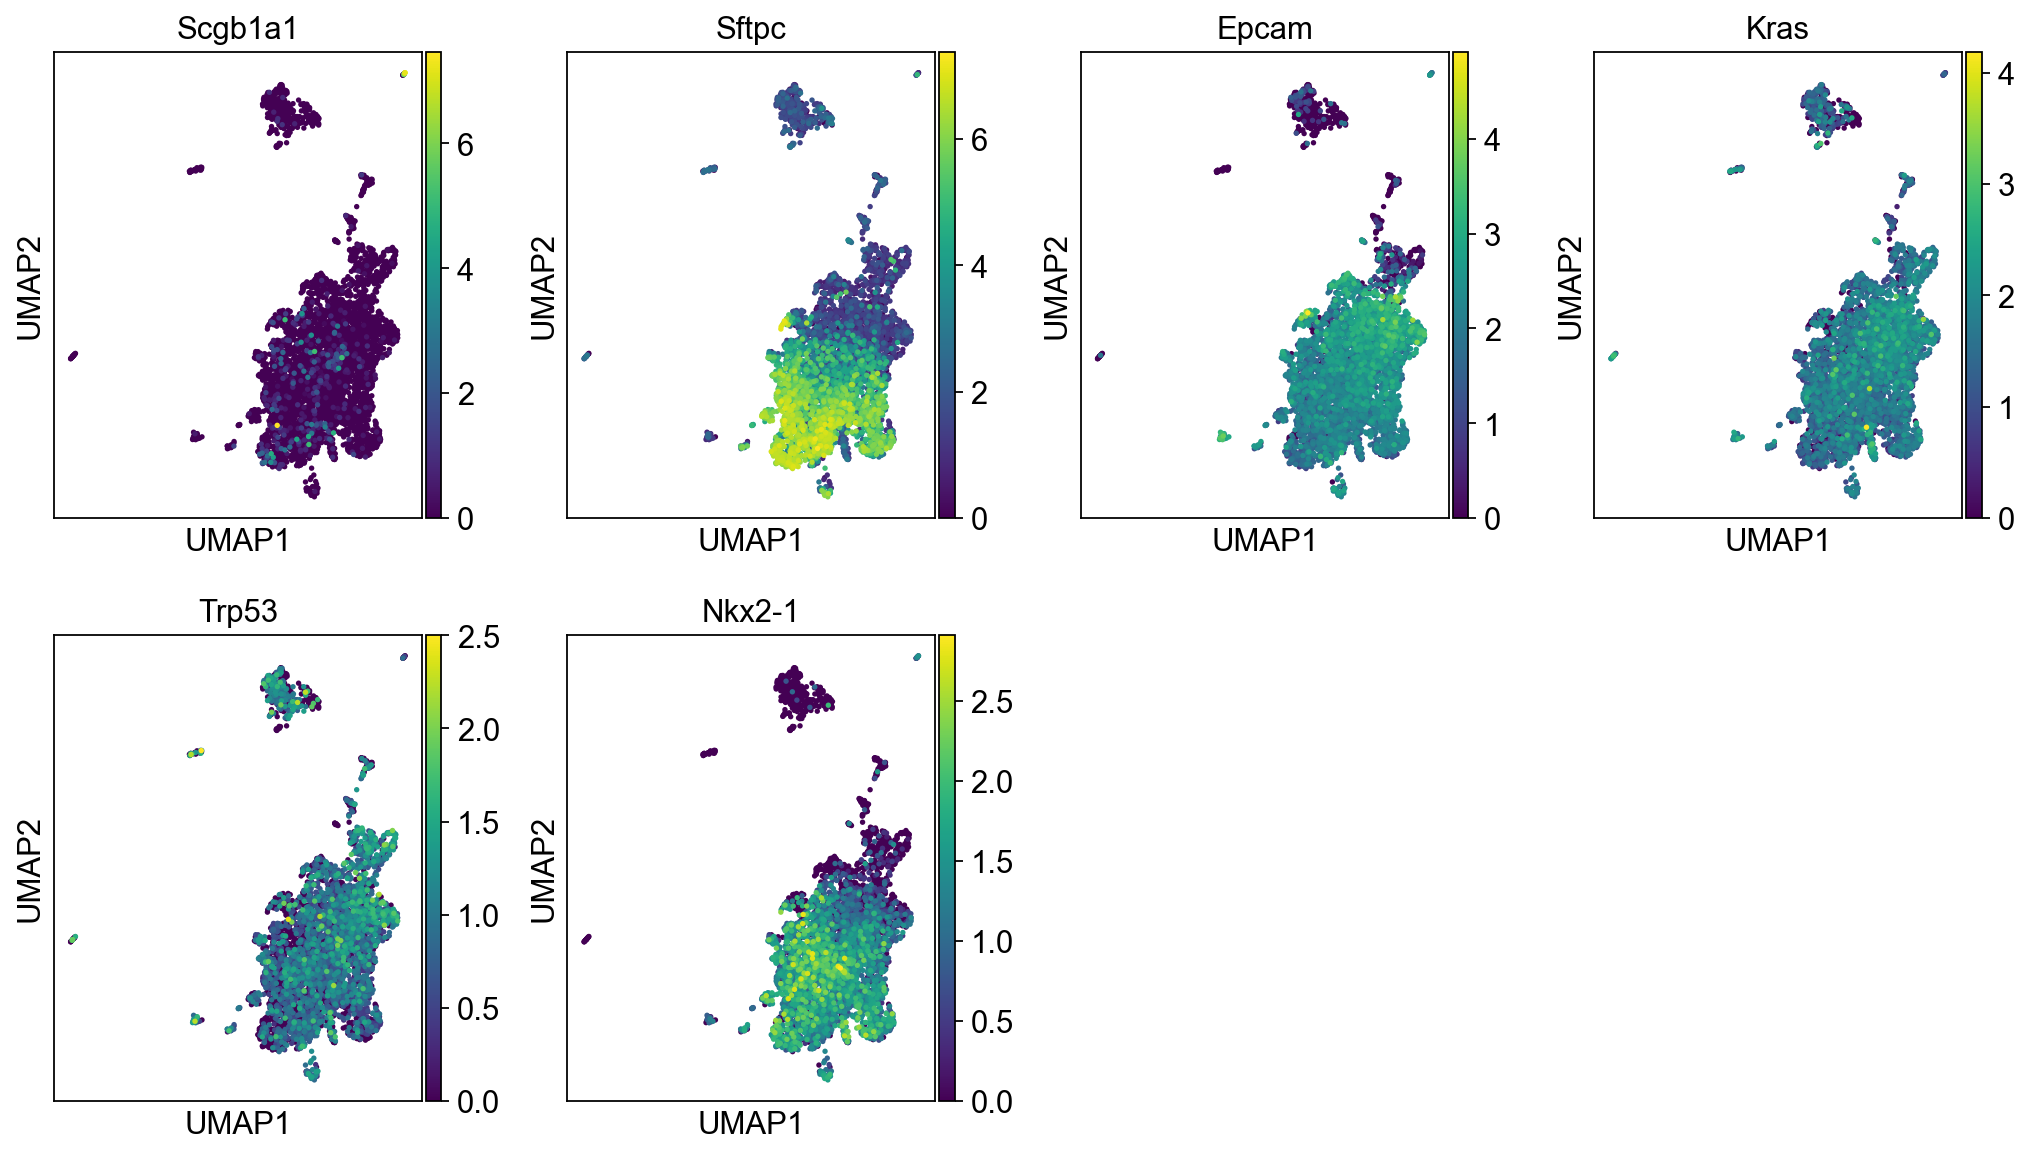

In [75]:
sc.pl.umap(adata, color=['Scgb1a1','Sftpc','Epcam','Kras', 'Trp53','Nkx2-1'])

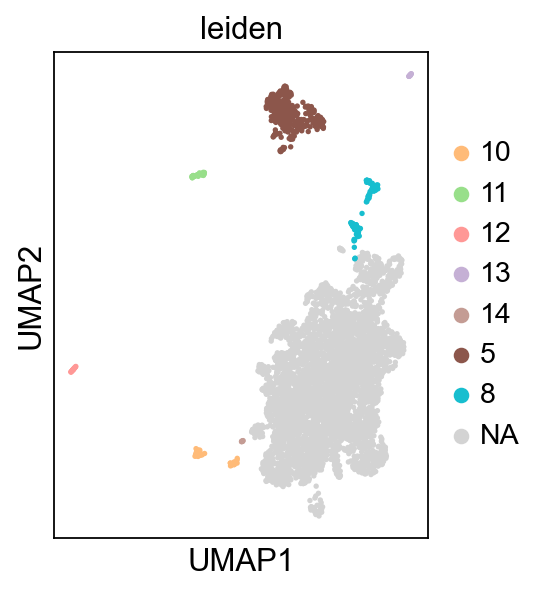

In [76]:
sc.pl.umap(adata, color=['leiden'], groups=['5','8','10','11','12','13','14'])

## End Analysis

In [77]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO16562.h5ad')
adata = adata2[~adata.obs['leiden'].isin(['5','8','10','11','12','13','14']),:] # keep tumor cells
del adata2

In [78]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [79]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [80]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/1996744496.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_76866/199674

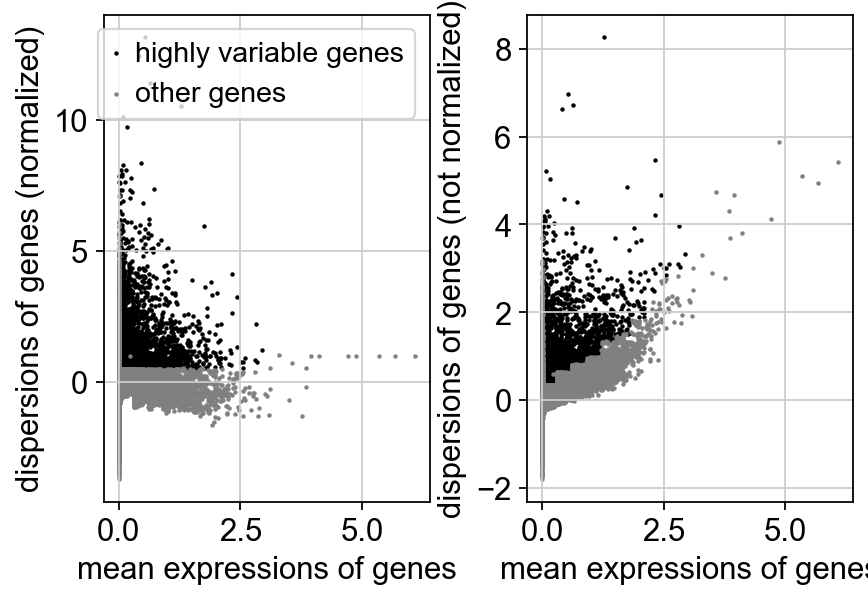

In [81]:
sc.pl.highly_variable_genes(adata)

In [82]:
adata.raw = adata

In [83]:
adata.write('write/allmice-tumor-IGO16562.h5ad', compression='gzip')
#adata = sc.read('write/allmice-tumor.h5ad')